In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --force-reinstall qutip scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 124.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.


  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 125.1 MB/s eta 0:00:00
Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 30.7 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Successfully uninstalled PyYAML-6.0.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: numpy
  

/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip

Optimized parameters: fx=0.549, delta=1.065, gamma=1.000
Minimum final energy: -3.1367


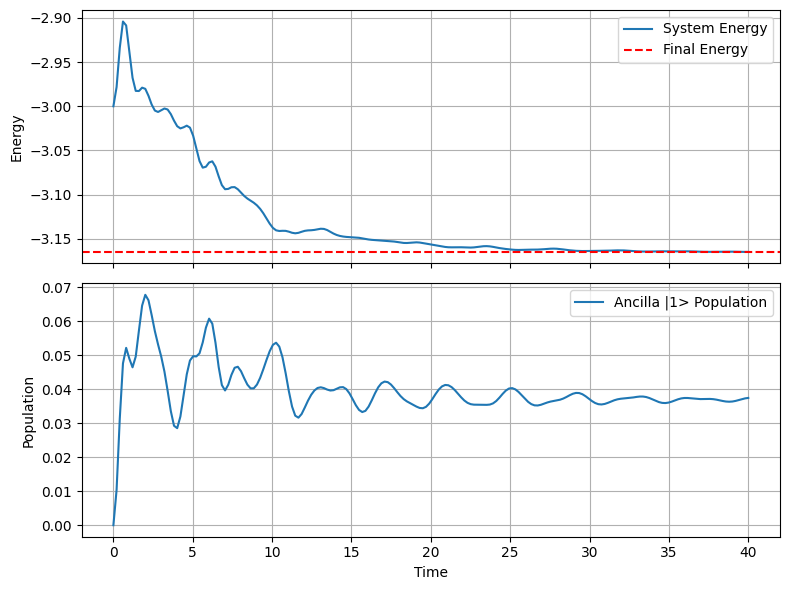

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# Helper: build qutrit single-step lowering operator for ancilla
# =============================================================================
def make_qutrit_lowering(n_sys):
    """
    Build L = |0><1| acting on the ancilla (3-level system),
    tensored with identity on the n_sys qubits.
    """
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)


# =============================================================================
# Build transverse-field Ising Hamiltonian for n_sys qubits + qutrit ancilla
# =============================================================================
def build_hamiltonian(n_sys, J, hx, fx, delta):
    """
    Construct total Hamiltonian on (2^n_sys)×3 Hilbert space:
      H_sys ⊗ I_ancilla
    + I_system ⊗ H_bath
    + H_int coupling last qubit and ancilla.
    """
    # System TFIM on qubit space
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1)))
          for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1)))
          for i in range(n_sys)]
    H_sys_nq = sum(-J * sz[i] * sz[i+1] for i in range(n_sys - 1)) \
             + sum(-hx * sx[i] for i in range(n_sys))
    # Lift to full space: H_sys ⊗ I_3
    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    # Ancilla bath Hamiltonian
    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    # Interaction: σ_x(last qubit) ⊗ (|0><1| + |1><0|)
    anc_x = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    H_int = fx * qt.tensor(sx[-1], anc_x)

    return H_sys_full + H_bath_full + H_int


# =============================================================================
# Objective: simulate and return final system energy
# =============================================================================
n_sys = 4
J, hx = 1.0, 0.5

def simulate_and_energy(fx, delta, gamma):
    # Build total Hamiltonian
    H_tot = build_hamiltonian(n_sys, J, hx, fx, delta)
    # Build collapse operator for ancilla
    L_anc = make_qutrit_lowering(n_sys)
    c_ops = [np.sqrt(gamma) * L_anc]

    # Initial state: system in |1>^n, ancilla in |0>
    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))

    # Time list for short optimization run
    tlist = np.linspace(0, 10, 50)

    # System energy operator for expectation: H_sys ⊗ I_3
    H_sys_full = build_hamiltonian(n_sys, J, hx, 0, 0)  # fx=0, delta=0 yields only H_sys_full
    e_ops = [H_sys_full]

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=e_ops,
                        options=qt.Options(store_states=False))
    # Return final system energy
    return float(result.expect[0][-1])


# =============================================================================
# Bayesian optimization over fx, delta, gamma
# =============================================================================
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma')
]

@use_named_args(space)
def objective(**kwargs):
    return simulate_and_energy(kwargs['fx'], kwargs['delta'], kwargs['gamma'])

result = gp_minimize(objective, space, n_calls=30, random_state=0)

best_fx, best_delta, best_gamma = result.x
print(f"Optimized parameters: fx={best_fx:.3f}, delta={best_delta:.3f}, gamma={best_gamma:.3f}")
print(f"Minimum final energy: {result.fun:.4f}")


# =============================================================================
# Final long simulation and plotting
# =============================================================================
# Rebuild with optimized parameters
H_tot = build_hamiltonian(n_sys, J, hx, best_fx, best_delta)
c_ops = [np.sqrt(best_gamma) * make_qutrit_lowering(n_sys)]
psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
tlist = np.linspace(0, 40, 200)

# Operators to track: system energy and ancilla |1> population
H_sys_full = build_hamiltonian(n_sys, J, hx, 0, 0)
proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
anc_pop = qt.tensor(qt.tensor([qt.qeye(2)] * n_sys), proj1)

res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_full, anc_pop])

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='System Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label='Final Energy')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1> Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

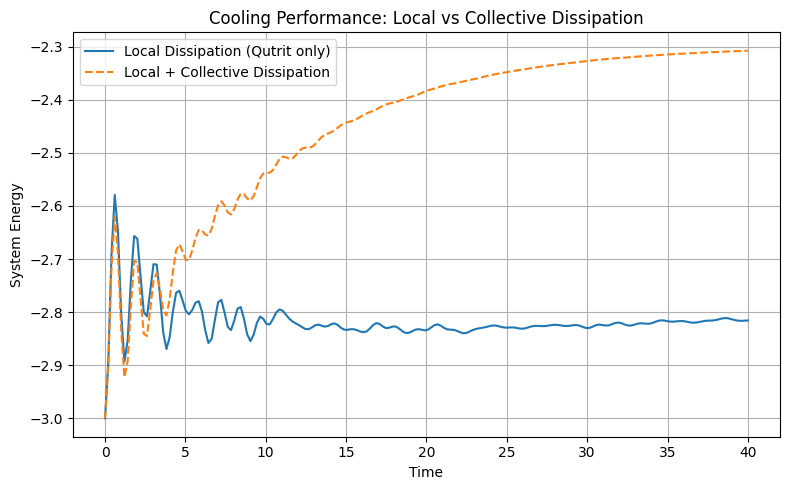

In [ ]:
# local vs collective system noise
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# System Parameters
# =============================================================================
n_sys = 4
J, hx = 1.0, 0.5

# Fixed parameters for comparison (can be from optimization)
fx = 1.2
delta = 1.0
gamma = 0.4
g_coll = 0.2

# =============================================================================
# Operators
# =============================================================================
def make_qutrit_lowering(n_sys):
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)

def make_collective_lowering(n_sys):
    id_q = qt.qeye(2)
    lowers = [qt.tensor(*([id_q] * i + [qt.sigmam()] + [id_q] * (n_sys - i - 1)))
              for i in range(n_sys)]
    L_coll = sum(lowers)
    return qt.tensor(L_coll, qt.qeye(3))

def build_hamiltonian(n_sys, J, hx, fx, delta):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]

    H_sys_nq = sum(-J * sz[i] * sz[i+1] for i in range(n_sys - 1)) \
             + sum(-hx * sx[i] for i in range(n_sys))
    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    anc_x = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    H_int = fx * qt.tensor(sx[-1], anc_x)

    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Simulation Function
# =============================================================================
def simulate_case(use_collective=False):
    H = build_hamiltonian(n_sys, J, hx, fx, delta)
    L_anc = make_qutrit_lowering(n_sys)
    c_ops = [np.sqrt(gamma) * L_anc]

    if use_collective:
        L_coll = make_collective_lowering(n_sys)
        c_ops.append(np.sqrt(g_coll) * L_coll)

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    tlist = np.linspace(0, 40, 200)

    H_sys_only = build_hamiltonian(n_sys, J, hx, 0, 0)
    res = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[H_sys_only])

    return tlist, res.expect[0]

# =============================================================================
# Run Both Simulations
# =============================================================================
t_local, E_local = simulate_case(use_collective=False)
t_coll, E_coll = simulate_case(use_collective=True)

# =============================================================================
# Plot Comparison
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(t_local, E_local, label='Local Dissipation (Qutrit only)')
plt.plot(t_coll, E_coll, label='Local + Collective Dissipation', linestyle='--')
plt.xlabel('Time')
plt.ylabel('System Energy')
plt.title('Cooling Performance: Local vs Collective Dissipation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔄 Optimizing for Local Dissipation...
✅ Done.
🔄 Optimizing for Local + Collective Dissipation...
✅ Done.

🎯 Exact TFIM Ground Energy (n = 4): -3.4270


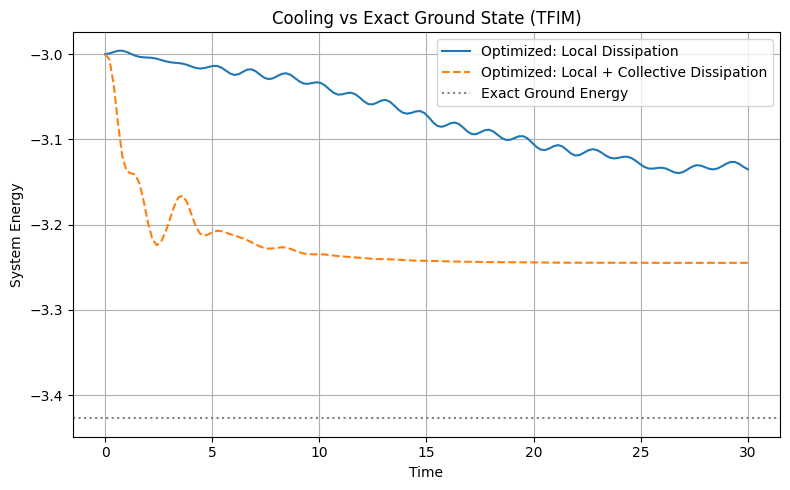


📌 Optimized Parameters (Local only):
fx = 0.100, delta = 0.819, gamma = 0.010, g_coll = 0.000
Final Energy: -3.1351

📌 Optimized Parameters (Local + Collective):
fx = 0.100, delta = 3.000, gamma = 0.010, g_coll = 0.500
Final Energy: -3.2447


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# System Parameters
# =============================================================================
n_sys = 4
J, hx = 1.0, 0.5
tlist = np.linspace(0, 30, 150)

# =============================================================================
# Operators
# =============================================================================
def make_qutrit_lowering(n_sys):
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)

def make_collective_lowering(n_sys):
    id_q = qt.qeye(2)
    lowers = [qt.tensor(*([id_q] * i + [qt.sigmam()] + [id_q] * (n_sys - i - 1)))
              for i in range(n_sys)]
    L_coll = sum(lowers)
    return qt.tensor(L_coll, qt.qeye(3))

def build_hamiltonian(n_sys, J, hx, fx, delta):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]

    H_sys_nq = sum(-J * sz[i] * sz[i+1] for i in range(n_sys - 1)) \
             + sum(-hx * sx[i] for i in range(n_sys))
    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    anc_x = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    H_int = fx * qt.tensor(sx[-1], anc_x)

    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Simulation Function
# =============================================================================
def simulate_and_energy(fx, delta, gamma, g_coll, use_collective=False):
    H = build_hamiltonian(n_sys, J, hx, fx, delta)
    L_anc = make_qutrit_lowering(n_sys)
    c_ops = [np.sqrt(gamma) * L_anc]

    if use_collective:
        L_coll = make_collective_lowering(n_sys)
        c_ops.append(np.sqrt(g_coll) * L_coll)

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    H_sys_only = build_hamiltonian(n_sys, J, hx, 0, 0)

    res = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[H_sys_only])
    return float(res.expect[0][-1])  # Final energy

# =============================================================================
# Compute exact TFIM ground state energy via ED
# =============================================================================
def compute_exact_ground_energy_tfim(n_sys, J, hx):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]

    H_sys = sum(-J * sz[i] * sz[i+1] for i in range(n_sys - 1)) + sum(-hx * sx[i] for i in range(n_sys))
    evals = H_sys.eigenenergies()
    return np.min(evals)

# =============================================================================
# Bayesian Optimization for Local and Collective Cases
# =============================================================================
space = [
    Real(0.1, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma'),
    Real(0.0, 0.5, name='g_coll')  # Will be ignored if use_collective=False
]

def run_optimization(use_collective):
    @use_named_args(space)
    def objective(**params):
        return simulate_and_energy(**params, use_collective=use_collective)

    result = gp_minimize(objective, space, n_calls=25, random_state=42)
    return result

print("🔄 Optimizing for Local Dissipation...")
res_local = run_optimization(use_collective=False)
print("✅ Done.")

print("🔄 Optimizing for Local + Collective Dissipation...")
res_coll = run_optimization(use_collective=True)
print("✅ Done.")

# =============================================================================
# Run Final Simulation for Best Params
# =============================================================================
opt_local = res_local.x
opt_coll = res_coll.x

def run_final_sim(params, use_collective=False):
    fx, delta, gamma, g_coll = params
    H = build_hamiltonian(n_sys, J, hx, fx, delta)
    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    c_ops = [np.sqrt(gamma) * make_qutrit_lowering(n_sys)]
    if use_collective:
        c_ops.append(np.sqrt(g_coll) * make_collective_lowering(n_sys))
    H_sys_only = build_hamiltonian(n_sys, J, hx, 0, 0)
    result = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[H_sys_only])
    return result.expect[0]

E_local = run_final_sim(opt_local, use_collective=False)
E_coll = run_final_sim(opt_coll, use_collective=True)

# =============================================================================
# Compute Exact Ground Energy
# =============================================================================
E_exact = compute_exact_ground_energy_tfim(n_sys, J, hx)
print(f"\n🎯 Exact TFIM Ground Energy (n = {n_sys}): {E_exact:.4f}")

# =============================================================================
# Plot Comparison
# =============================================================================
plt.figure(figsize=(8, 5))
plt.plot(tlist, E_local, label='Optimized: Local Dissipation')
plt.plot(tlist, E_coll, label='Optimized: Local + Collective Dissipation', linestyle='--')
plt.axhline(E_exact, color='gray', linestyle=':', label='Exact Ground Energy')
plt.xlabel('Time')
plt.ylabel('System Energy')
plt.title('Cooling vs Exact Ground State (TFIM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# Print Optimized Parameters
# =============================================================================
print("\n📌 Optimized Parameters (Local only):")
print(f"fx = {opt_local[0]:.3f}, delta = {opt_local[1]:.3f}, gamma = {opt_local[2]:.3f}, g_coll = 0.000")
print(f"Final Energy: {res_local.fun:.4f}")

print("\n📌 Optimized Parameters (Local + Collective):")
print(f"fx = {opt_coll[0]:.3f}, delta = {opt_coll[1]:.3f}, gamma = {opt_coll[2]:.3f}, g_coll = {opt_coll[3]:.3f}")
print(f"Final Energy: {res_coll.fun:.4f}")


In [ ]:
!pip install git+https://github.com/tenpy/tenpy.git


  Cloning https://github.com/tenpy/tenpy.git to /tmp/pip-req-build-ypb1r3_b
  Running command git clone --filter=blob:none --quiet https://github.com/tenpy/tenpy.git /tmp/pip-req-build-ypb1r3_b
  Resolved https://github.com/tenpy/tenpy.git to commit 58be04077ae961e804dfb89e474d1dc922b05ed6
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for physics-tenpy: filename=physics_tenpy-1.0.6-cp311-cp311-linux_x86_64.whl size=2281951 sha256=4a72e62177a5f45a99bbdce0e821dfed4360c4dce4831864d0bcee01f610d267
  Stored in directory: /tmp/pip-ephem-wheel-cache-okvgnb3f/wheels/62/dc/14/b19751612059fb70b13df40768c891aea55fe276aa375b7c87
Successfully built physics-tenpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tenpy.models.lattice import Chain
from tenpy.networks.site import SpinSite
from tenpy.models.model import CouplingMPOModel
from tenpy.networks.mps import MPS
from tenpy.algorithms.tebd import TEBD

# =============================================================================
# Parameters
# =============================================================================
n_sys = 4
J, hx = 1.0, 0.5
fx = 1.2
delta = 1.0
dt = 0.05
steps = 300

# =============================================================================
# Define Sites (Spin-½ for qubits, Spin-1 for qutrit ancilla)
# =============================================================================
qubit_site = SpinSite(S=0.5, conserve=None)
qutrit_site = SpinSite(S=1, conserve=None)
sites = [qubit_site] * n_sys + [qutrit_site]
L = len(sites)
lat = Chain(L, site=sites)

# =============================================================================
# Define CouplingMPOModel
# =============================================================================
model_params = {
    'lattice': lat,
    'coupling_terms': [],
    'cons_N': None
}
H = CouplingMPOModel(model_params)

# TFIM: -J * σᶻᵢ σᶻᵢ₊₁
for i in range(n_sys - 1):
    H.add_coupling(-J, i, 'Sz', i+1, 'Sz', plus_hc=False)

# Transverse field: -hx * σˣᵢ
for i in range(n_sys):
    H.add_onsite(-hx, i, 'Sx')

# Ancilla energy splitting: +delta * Sz on qutrit
H.add_onsite(delta, n_sys, 'Sz')

# Coupling last qubit to ancilla: fx * σˣ ⊗ Sˣ
H.add_coupling(fx, n_sys - 1, 'Sx', n_sys, 'Sx')

# Build MPO
H_mpo = H.H_MPO

# =============================================================================
# Initial MPDO as MPS of a pure state |↓↓…↓⟩ ⊗ |0⟩
# =============================================================================
product_state = ['down'] * n_sys + ['down']
psi = MPS.from_product_state(sites, product_state, bc='finite', form='mpdo')

# =============================================================================
# TEBD Evolution
# =============================================================================
tebd_params = {
    'dt': dt,
    'N_steps': steps,
    'trunc_params': {
        'chi_max': 100,
        'svd_min': 1e-10
    },
    'verbose': True
}

engine = TEBD(psi, H_mpo, tebd_params)

energies = []
for i in range(steps):
    engine.run_one_step()
    energy = psi.expectation_value(H_mpo)
    energies.append(energy)

# =============================================================================
# Plot Energy vs Time
# =============================================================================
times = np.arange(steps) * dt
plt.plot(times, energies, label='System Energy (MPDO)')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Cooling Dynamics via MPDO (TEBD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ImportError: cannot import name 'TEBD' from 'tenpy.algorithms.tebd' (/usr/local/lib/python3.11/dist-packages/tenpy/algorithms/tebd.py)

In [ ]:
# System TFIM on qubit space
min(H_sys_full.eigenenergies())



np.float64(-3.4270340889080813)

/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip

Optimized parameters: fx=0.367, delta=1.045, gamma=0.010
Minimum final energy: -5.1286


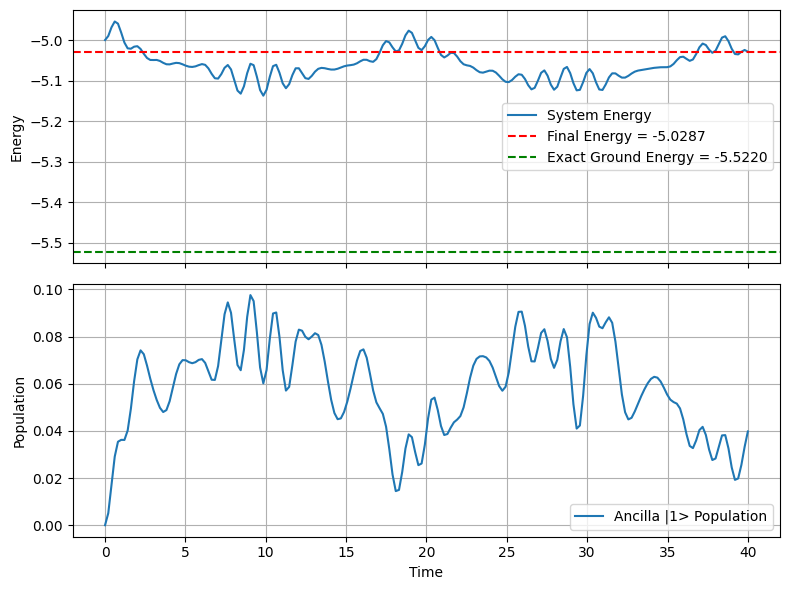

In [ ]:
o§    §import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# Helper: build qutrit single-step lowering operator for ancilla
# =============================================================================
def make_qutrit_lowering(n_sys):
    """
    Build L = |0><1| acting on the ancilla (3-level system),
    tensored with identity on the n_sys qubits.
    """
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)

# =============================================================================
# Build transverse-field Ising Hamiltonian for n_sys qubits + qutrit ancilla
# =============================================================================
def build_hamiltonian(n_sys, J, hx, fx, delta):
    """
    Construct total Hamiltonian on (2^n_sys)×3 Hilbert space:
      H_sys ⊗ I_ancilla
    + I_system ⊗ H_bath
    + H_int coupling last qubit and ancilla.
    """
    # System TFIM on qubit space
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1)))
          for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1)))
          for i in range(n_sys)]
    H_sys_nq = sum(-J * sz[i] * sz[i+1] for i in range(n_sys - 1)) \
             + sum(-hx * sx[i] for i in range(n_sys))

    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    # Ancilla bath Hamiltonian
    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    # Interaction: σ_x(last qubit) ⊗ (|0><1| + |1><0|)
    anc_x = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    H_int = fx * qt.tensor(sx[-1], anc_x)

    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Objective: simulate and return final system energy
# =============================================================================
n_sys = 6
J, hx = 1.0, 0.5

def simulate_and_energy(fx, delta, gamma):
    H_tot = build_hamiltonian(n_sys, J, hx, fx, delta)
    L_anc = make_qutrit_lowering(n_sys)
    c_ops = [np.sqrt(gamma) * L_anc]

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    tlist = np.linspace(0, 10, 50)

    H_sys_full = build_hamiltonian(n_sys, J, hx, 0, 0)
    e_ops = [H_sys_full]

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=e_ops,
                        options=qt.Options(store_states=False))
    return float(result.expect[0][-1])

# =============================================================================
# Bayesian optimization over fx, delta, gamma
# =============================================================================
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma')
]

@use_named_args(space)
def objective(**kwargs):
    return simulate_and_energy(kwargs['fx'], kwargs['delta'], kwargs['gamma'])

result = gp_minimize(objective, space, n_calls=30, random_state=0)

best_fx, best_delta, best_gamma = result.x
print(f"Optimized parameters: fx={best_fx:.3f}, delta={best_delta:.3f}, gamma={best_gamma:.3f}")
print(f"Minimum final energy: {result.fun:.4f}")

# =============================================================================
# Final long simulation and plotting
# =============================================================================
H_tot = build_hamiltonian(n_sys, J, hx, best_fx, best_delta)
c_ops = [np.sqrt(best_gamma) * make_qutrit_lowering(n_sys)]
psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
tlist = np.linspace(0, 40, 200)

H_sys_full = build_hamiltonian(n_sys, J, hx, 0, 0)
proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
anc_pop = qt.tensor(qt.tensor([qt.qeye(2)] * n_sys), proj1)

res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_full, anc_pop])

# Compute exact ground state energy
e_sys_exact = H_sys_full.eigenenergies()[0]

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='System Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label=f'Final Energy = {res.expect[0][-1]:.4f}')
axes[0].axhline(e_sys_exact, ls='--', c='g', label=f'Exact Ground Energy = {e_sys_exact:.4f}')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1> Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip

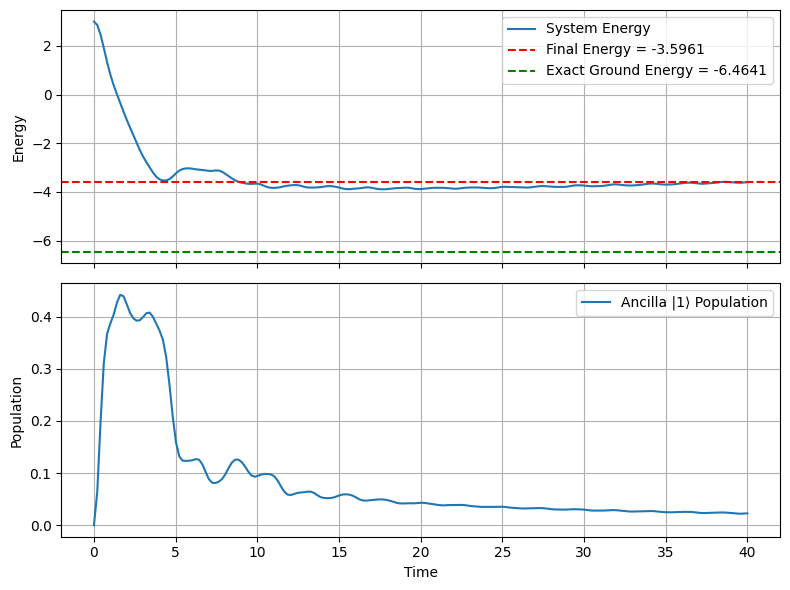

Optimized parameters: fx=0.668, delta=2.430, gamma=0.650
Minimum final energy: -3.6595


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# Helper: build qutrit single-step lowering operator for ancilla
# =============================================================================
def make_qutrit_lowering(n_sys):
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)

# =============================================================================
# Symmetric spin-spin interaction between system and ancilla (SU(2)-symmetric)
# =============================================================================
def build_symmetric_interaction(n_sys, fx):
    # Qutrit SU(2)-like ops (|0><1| + |1><0|, etc.)
    sx_a = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    sy_a = -1j * (qt.basis(3, 0) * qt.basis(3, 1).dag() - qt.basis(3, 1) * qt.basis(3, 0).dag())
    sz_a = qt.basis(3, 0) * qt.basis(3, 0).dag() - qt.basis(3, 1) * qt.basis(3, 1).dag()

    id_q = qt.qeye(2)
    sx_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmax()]))
    sy_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmay()]))
    sz_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmaz()]))

    H_int = fx * (
        qt.tensor(sx_n, sx_a) +
        qt.tensor(sy_n, sy_a) +
        qt.tensor(sz_n, sz_a)
    )
    return H_int

# =============================================================================
# Build Heisenberg Hamiltonian (XXX) for n_sys qubits + qutrit ancilla
# =============================================================================
def build_heisenberg_hamiltonian(n_sys, J, fx, delta):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sy = [qt.tensor(*([id_q] * i + [qt.sigmay()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]

    H_sys_nq = sum(J * (sx[i] * sx[i + 1] + sy[i] * sy[i + 1] + sz[i] * sz[i + 1])
                   for i in range(n_sys - 1))
    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    H_int = build_symmetric_interaction(n_sys, fx)
    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Objective: simulate and return final system energy
# =============================================================================
n_sys = 4
J = 1.0

def simulate_and_energy(fx, delta, gamma):
    H_tot = build_heisenberg_hamiltonian(n_sys, J, fx, delta)
    L_anc = make_qutrit_lowering(n_sys)
    c_ops = [np.sqrt(gamma) * L_anc]

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    tlist = np.linspace(0, 10, 50)

    H_sys_full = build_heisenberg_hamiltonian(n_sys, J, 0, 0)
    e_ops = [H_sys_full]

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=e_ops,
                        options=qt.Options(store_states=False))
    return float(result.expect[0][-1])

# =============================================================================
# Bayesian optimization over fx, delta, gamma
# =============================================================================
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma')
]

@use_named_args(space)
def objective(**kwargs):
    return simulate_and_energy(kwargs['fx'], kwargs['delta'], kwargs['gamma'])

result = gp_minimize(objective, space, n_calls=30, random_state=0)
best_fx, best_delta, best_gamma = result.x

# =============================================================================
# Final long simulation and plotting
# =============================================================================
H_tot = build_heisenberg_hamiltonian(n_sys, J, best_fx, best_delta)
c_ops = [np.sqrt(best_gamma) * make_qutrit_lowering(n_sys)]
psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
tlist = np.linspace(0, 40, 200)

H_sys_full = build_heisenberg_hamiltonian(n_sys, J, 0, 0)
proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
anc_pop = qt.tensor(qt.tensor([qt.qeye(2)] * n_sys), proj1)

res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_full, anc_pop])
e_sys_exact = H_sys_full.eigenenergies()[0]

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='System Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label=f'Final Energy = {res.expect[0][-1]:.4f}')
axes[0].axhline(e_sys_exact, ls='--', c='g', label=f'Exact Ground Energy = {e_sys_exact:.4f}')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1⟩ Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print optimal parameters
print(f"Optimized parameters: fx={best_fx:.3f}, delta={best_delta:.3f}, gamma={best_gamma:.3f}")
print(f"Minimum final energy: {result.fun:.4f}")


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# Helper: build qutrit single-step lowering operator for ancilla
# =============================================================================
def make_qutrit_lowering(n_sys):
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    return qt.tensor(id_sys, lower_1step)

# =============================================================================
# SU(2)-symmetric interaction
# =============================================================================
def build_symmetric_interaction(n_sys, fx):
    sx_a = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    sy_a = -1j * (qt.basis(3, 0) * qt.basis(3, 1).dag() - qt.basis(3, 1) * qt.basis(3, 0).dag())
    sz_a = qt.basis(3, 0) * qt.basis(3, 0).dag() - qt.basis(3, 1) * qt.basis(3, 1).dag()

    id_q = qt.qeye(2)
    sx_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmax()]))
    sy_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmay()]))
    sz_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmaz()]))

    H_int = fx * (
        qt.tensor(sx_n, sx_a) +
        qt.tensor(sy_n, sy_a) +
        qt.tensor(sz_n, sz_a)
    )
    return H_int

# =============================================================================
# Build Heisenberg Hamiltonian (XXX) for n_sys qubits + qutrit ancilla
# =============================================================================
def build_heisenberg_hamiltonian(n_sys, J, fx, delta):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sy = [qt.tensor(*([id_q] * i + [qt.sigmay()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]

    H_sys_nq = sum(J * (sx[i] * sx[i + 1] + sy[i] * sy[i + 1] + sz[i] * sz[i + 1])
                   for i in range(n_sys - 1))
    id_a = qt.qeye(3)
    H_sys_full = qt.tensor(H_sys_nq, id_a)

    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)
    H_bath_full = qt.tensor(id_sys, H_bath)

    H_int = build_symmetric_interaction(n_sys, fx)
    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Objective: simulate and return final system energy
# =============================================================================
n_sys = 6
J = 1.0

def simulate_and_energy(fx, delta, gamma1, gamma2):
    H_tot = build_heisenberg_hamiltonian(n_sys, J, fx, delta)

    id_sys = qt.tensor([qt.qeye(2)] * n_sys)

    # |1⟩ → |0⟩ transition
    L1_op = qt.basis(3, 0) * qt.basis(3, 1).dag()
    L1 = qt.tensor(id_sys, L1_op)

    # |2⟩ → |1⟩ transition
    L2_op = qt.basis(3, 1) * qt.basis(3, 2).dag()
    L2 = qt.tensor(id_sys, L2_op)

    c_ops = [np.sqrt(gamma1) * L1, np.sqrt(gamma2) * L2]

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    tlist = np.linspace(0, 10, 50)

    H_sys_full = build_heisenberg_hamiltonian(n_sys, J, 0, 0)
    e_ops = [H_sys_full]

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=e_ops,
                        options=qt.Options(store_states=False))
    return float(result.expect[0][-1])

# =============================================================================
# Bayesian optimization over fx, delta, gamma1, gamma2
# =============================================================================
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma1'),
    Real(0.01, 1.0, name='gamma2'),
]

@use_named_args(space)
def objective(**kwargs):
    return simulate_and_energy(kwargs['fx'], kwargs['delta'], kwargs['gamma1'], kwargs['gamma2'])

result = gp_minimize(objective, space, n_calls=30, random_state=0)
best_fx, best_delta, best_gamma1, best_gamma2 = result.x

# =============================================================================
# Final long simulation and plotting
# =============================================================================
H_tot = build_heisenberg_hamiltonian(n_sys, J, best_fx, best_delta)

id_sys = qt.tensor([qt.qeye(2)] * n_sys)
L1 = qt.tensor(id_sys, qt.basis(3, 0) * qt.basis(3, 1).dag())
L2 = qt.tensor(id_sys, qt.basis(3, 1) * qt.basis(3, 2).dag())
c_ops = [np.sqrt(best_gamma1) * L1, np.sqrt(best_gamma2) * L2]

psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
tlist = np.linspace(0, 40, 200)

H_sys_full = build_heisenberg_hamiltonian(n_sys, J, 0, 0)
proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
anc_pop = qt.tensor(id_sys, proj1)

res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_full, anc_pop])
e_sys_exact = H_sys_full.eigenenergies()[0]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='System Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label=f'Final Energy = {res.expect[0][-1]:.4f}')
axes[0].axhline(e_sys_exact, ls='--', c='g', label=f'Exact Ground Energy = {e_sys_exact:.4f}')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1⟩ Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

# Report optimal parameters
print(f"Optimized parameters:")
print(f"  fx     = {best_fx:.3f}")
print(f"  delta  = {best_delta:.3f}")
print(f"  gamma1 = {best_gamma1:.3f} (|1⟩→|0⟩)")
print(f"  gamma2 = {best_gamma2:.3f} (|2⟩→|1⟩)")
print(f"Minimum final system energy: {result.fun:.4f}")


ModuleNotFoundError: No module named 'qutip'

In [ ]:
n_sys


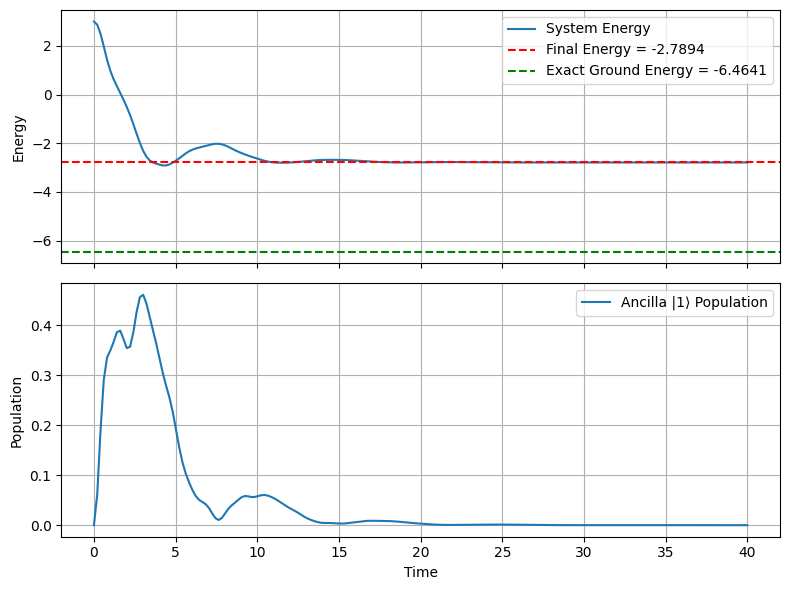

Negative Temp Bath Optimization Results:
  fx     = 0.648
  delta  = 2.663
  gamma1 = 0.010 (|0⟩→|1⟩)
  gamma2 = 0.469 (|1⟩→|2⟩)
Minimum final system energy: -2.7894


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# SU(2)-symmetric system-ancilla interaction
# =============================================================================
def build_symmetric_interaction(n_sys, fx):
    sx_a = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    sy_a = -1j * (qt.basis(3, 0) * qt.basis(3, 1).dag() - qt.basis(3, 1) * qt.basis(3, 0).dag())
    sz_a = qt.basis(3, 0) * qt.basis(3, 0).dag() - qt.basis(3, 1) * qt.basis(3, 1).dag()

    id_q = qt.qeye(2)
    sx_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmax()]))
    sy_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmay()]))
    sz_n = qt.tensor(*([id_q] * (n_sys - 1) + [qt.sigmaz()]))

    return fx * (qt.tensor(sx_n, sx_a) + qt.tensor(sy_n, sy_a) + qt.tensor(sz_n, sz_a))

# =============================================================================
# Build Heisenberg Hamiltonian for system + qutrit ancilla
# =============================================================================
def build_heisenberg_hamiltonian(n_sys, J, fx, delta):
    id_q = qt.qeye(2)
    sx = [qt.tensor(*([id_q] * i + [qt.sigmax()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sy = [qt.tensor(*([id_q] * i + [qt.sigmay()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    sz = [qt.tensor(*([id_q] * i + [qt.sigmaz()] + [id_q] * (n_sys - i - 1))) for i in range(n_sys)]
    H_sys = sum(J * (sx[i] * sx[i+1] + sy[i] * sy[i+1] + sz[i] * sz[i+1]) for i in range(n_sys - 1))
    H_sys_full = qt.tensor(H_sys, qt.qeye(3))

    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H_bath = delta * (proj1 - proj0)
    H_bath_full = qt.tensor(qt.tensor([qt.qeye(2)] * n_sys), H_bath)

    H_int = build_symmetric_interaction(n_sys, fx)
    return H_sys_full + H_bath_full + H_int

# =============================================================================
# Negative temperature dissipation simulation
# =============================================================================
def simulate_negative_bath(fx, delta, gamma1, gamma2):
    H_tot = build_heisenberg_hamiltonian(n_sys, J, fx, delta)
    id_sys = qt.tensor([qt.qeye(2)] * n_sys)

    # Inverted channels (population flows up): |0>->|1>, |1>->|2>
    L1_inv = qt.tensor(id_sys, qt.basis(3, 1) * qt.basis(3, 0).dag())
    L2_inv = qt.tensor(id_sys, qt.basis(3, 2) * qt.basis(3, 1).dag())
    c_ops = [np.sqrt(gamma1) * L1_inv, np.sqrt(gamma2) * L2_inv]

    psi0 = qt.tensor(*([qt.basis(2, 1)] * n_sys + [qt.basis(3, 0)]))
    tlist = np.linspace(0, 40, 200)

    H_sys_full = build_heisenberg_hamiltonian(n_sys, J, 0, 0)
    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    anc_pop = qt.tensor(id_sys, proj1)

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_full, anc_pop])
    return result, H_sys_full.eigenenergies()[0]

# =============================================================================
# Optimization wrapper for negative bath
# =============================================================================
n_sys = 4
J = 1.0

def objective_neg(fx, delta, gamma1, gamma2):
    res, _ = simulate_negative_bath(fx, delta, gamma1, gamma2)
    return float(res.expect[0][-1])  # final energy

space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma1'),
    Real(0.01, 1.0, name='gamma2'),
]

@use_named_args(space)
def objective(**kwargs):
    return objective_neg(kwargs['fx'], kwargs['delta'], kwargs['gamma1'], kwargs['gamma2'])

result = gp_minimize(objective, space, n_calls=30, random_state=42)
best_fx, best_delta, best_gamma1, best_gamma2 = result.x

# =============================================================================
# Run and plot final optimized simulation
# =============================================================================
res, e_exact = simulate_negative_bath(best_fx, best_delta, best_gamma1, best_gamma2)

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='System Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label=f'Final Energy = {res.expect[0][-1]:.4f}')
axes[0].axhline(e_exact, ls='--', c='g', label=f'Exact Ground Energy = {e_exact:.4f}')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1⟩ Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()

# Output optimal parameters
print(f"Negative Temp Bath Optimization Results:")
print(f"  fx     = {best_fx:.3f}")
print(f"  delta  = {best_delta:.3f}")
print(f"  gamma1 = {best_gamma1:.3f} (|0⟩→|1⟩)")
print(f"  gamma2 = {best_gamma2:.3f} (|1⟩→|2⟩)")
print(f"Minimum final system energy: {result.fun:.4f}")


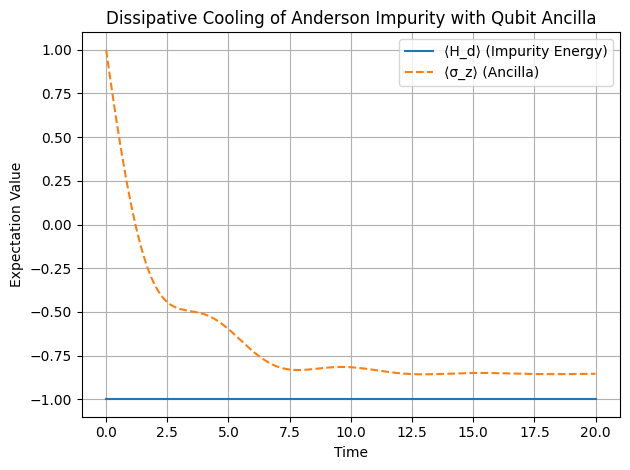

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon_d = -1.0    # impurity energy level
U = 2.0             # on-site interaction
delta = 0.5         # ancilla energy splitting
fx = 0.3            # interaction strength
gamma = 0.5         # dissipation rate

# Operators
I4 = qt.qeye(4)     # 4-level impurity basis
I2 = qt.qeye(2)     # 2-level ancilla basis

# Fermionic creation/annihilation operators for impurity
c_up = qt.Qobj([[0, 1, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, -1],
                [0, 0, 0, 0]])
c_down = qt.Qobj([[0, 0, 1, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 1, 0, 0]])
n_up = c_up.dag() * c_up
n_down = c_down.dag() * c_down

# Hamiltonians
H_d = epsilon_d * n_up + epsilon_d * n_down + U * n_up * n_down
H_d_full = qt.tensor(H_d, I2)
H_a = delta * qt.tensor(I4, qt.sigmaz())
H_int = fx * (qt.tensor(c_up + c_up.dag(), qt.sigmax()))
H_tot = H_d_full + H_a + H_int

# Collapse operator (dissipation on ancilla)
L = np.sqrt(gamma) * qt.tensor(I4, qt.sigmam())
c_ops = [L]

# Initial state
psi0 = qt.tensor(qt.basis(4, 3), qt.basis(2, 0))  # |↑↓⟩ ⊗ |0⟩

# Observables and simulation
tlist = np.linspace(0, 20, 200)
result = qt.mesolve(H_tot, psi0, tlist, c_ops,
                    e_ops=[H_d_full, qt.tensor(I4, qt.sigmaz())])

# Plot
plt.plot(tlist, result.expect[0], label='⟨H_d⟩ (Impurity Energy)')
plt.plot(tlist, result.expect[1], '--', label='⟨σ_z⟩ (Ancilla)')
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Dissipative Cooling of Anderson Impurity with Qubit Ancilla")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip

Optimized parameters: fx=0.789, delta=0.594, gamma=0.606
Minimum final energy: -1.7012


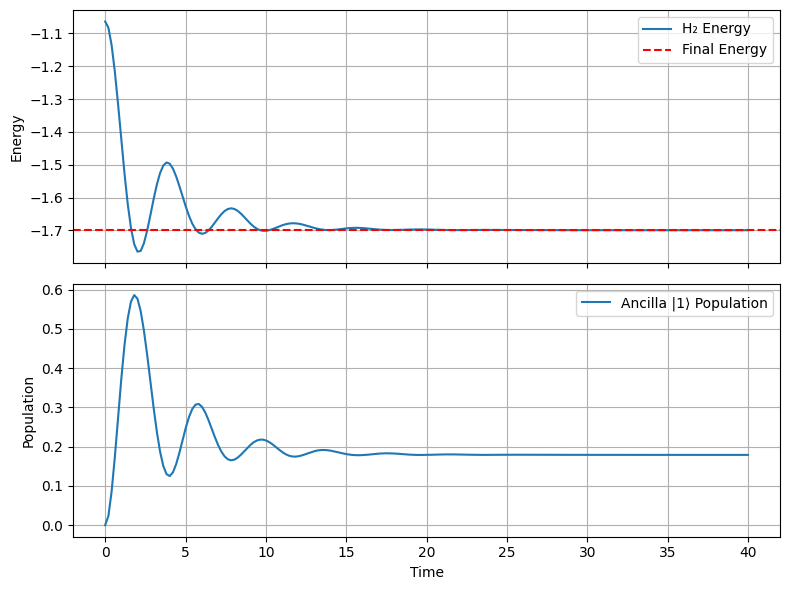

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# =============================================================================
# Coefficients for H2 molecule Hamiltonian (Jordan-Wigner, STO-3G, R=0.735 Å)
# =============================================================================
coeffs = {
    'I': -1.052373245772859,
    'Z0': 0.39793742484318045,
    'Z1': -0.39793742484318045,
    'Z0Z1': -0.01128010425623538,
    'X0X1': 0.18093119978423156,
    'Y0Y1': 0.18093119978423156
}

# =============================================================================
# Helper: kron3 = tensor(a, b, c)
# =============================================================================
def kron3(a, b, c):
    return qt.tensor(a, b, c)

# =============================================================================
# Qutrit ancilla lowering operator
# =============================================================================
def make_qutrit_lowering():
    lower_1step = qt.basis(3, 0) * qt.basis(3, 1).dag()
    return qt.tensor(qt.qeye(2), qt.qeye(2), lower_1step)

# =============================================================================
# Build H2 + qutrit Hamiltonian in full [2,2,3] space
# =============================================================================
def build_h2_qutrit_hamiltonian(fx, delta):
    I = qt.qeye(2)
    X = qt.sigmax()
    Y = qt.sigmay()
    Z = qt.sigmaz()
    I3 = qt.qeye(3)

    H = (
        coeffs['I'] * kron3(I, I, I3) +
        coeffs['Z0'] * kron3(Z, I, I3) +
        coeffs['Z1'] * kron3(I, Z, I3) +
        coeffs['Z0Z1'] * kron3(Z, Z, I3) +
        coeffs['X0X1'] * kron3(X, X, I3) +
        coeffs['Y0Y1'] * kron3(Y, Y, I3)
    )

    # Bath Hamiltonian
    proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
    proj0 = qt.basis(3, 0) * qt.basis(3, 0).dag()
    H += delta * kron3(I, I, proj1 - proj0)

    # Interaction: σ_x (qubit 1) ⊗ (|0><1| + |1><0|) on ancilla
    anc_x = qt.basis(3, 0) * qt.basis(3, 1).dag() + qt.basis(3, 1) * qt.basis(3, 0).dag()
    H += fx * kron3(I, X, anc_x)

    return H

# =============================================================================
# Objective: simulate dynamics and return final energy
# =============================================================================
def simulate_and_energy(fx, delta, gamma):
    H_tot = build_h2_qutrit_hamiltonian(fx, delta)
    L_anc = make_qutrit_lowering()
    c_ops = [np.sqrt(gamma) * L_anc]

    psi0 = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(3, 0))
    tlist = np.linspace(0, 10, 50)
    H_sys_only = build_h2_qutrit_hamiltonian(0, 0)

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_only],
                        options=qt.Options(store_states=False))
    return float(result.expect[0][-1])

# =============================================================================
# Optimization: minimize final system energy
# =============================================================================
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 1.0, name='gamma')
]

@use_named_args(space)
def objective(**kwargs):
    return simulate_and_energy(kwargs['fx'], kwargs['delta'], kwargs['gamma'])

result = gp_minimize(objective, space, n_calls=25, random_state=0)

best_fx, best_delta, best_gamma = result.x
print(f"Optimized parameters: fx={best_fx:.3f}, delta={best_delta:.3f}, gamma={best_gamma:.3f}")
print(f"Minimum final energy: {result.fun:.4f}")

# =============================================================================
# Final Simulation and Plotting
# =============================================================================
H_tot = build_h2_qutrit_hamiltonian(best_fx, best_delta)
c_ops = [np.sqrt(best_gamma) * make_qutrit_lowering()]
psi0 = qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(3, 0))
tlist = np.linspace(0, 40, 200)
H_sys_only = build_h2_qutrit_hamiltonian(0, 0)

proj1 = qt.basis(3, 1) * qt.basis(3, 1).dag()
anc_pop = qt.tensor(qt.qeye(2), qt.qeye(2), proj1)

res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_sys_only, anc_pop])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(res.times, res.expect[0], label='H₂ Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label='Final Energy')
axes[0].set_ylabel('Energy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(res.times, res.expect[1], label='Ancilla |1⟩ Population')
axes[1].set_ylabel('Population'); axes[1].set_xlabel('Time'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def exact_ground_state_energy_h2():
    I = qt.qeye(2)
    X = qt.sigmax()
    Y = qt.sigmay()
    Z = qt.sigmaz()

    # Construct H₂ Hamiltonian directly on 2-qubit space
    H_h2 = (
        coeffs['I'] * qt.tensor(I, I) +
        coeffs['Z0'] * qt.tensor(Z, I) +
        coeffs['Z1'] * qt.tensor(I, Z) +
        coeffs['Z0Z1'] * qt.tensor(Z, Z) +
        coeffs['X0X1'] * qt.tensor(X, X) +
        coeffs['Y0Y1'] * qt.tensor(Y, Y)
    )

    eigvals = H_h2.eigenenergies()
    return np.min(eigvals)


In [ ]:
exact_diag_energy = exact_ground_state_energy_h2()
print(f"Exact diagonalization energy: {exact_diag_energy:.6f}")


Exact diagonalization energy: -1.915371


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Hamiltonian coefficients for H₂ (STO-3G, JW encoding)
coeffs = {
    'I': -1.052373245772859,
    'Z0': 0.39793742484318045,
    'Z1': -0.39793742484318045,
    'Z0Z1': -0.01128010425623538,
    'X0X1': 0.18093119978423156,
    'Y0Y1': 0.18093119978423156
}

# Helper to tensor three systems
def kron3(a, b, c):
    return qt.tensor(a, b, c)

# Lowering operator for qubit ancilla: |0><1|
def make_qubit_lowering():
    return kron3(qt.qeye(2), qt.qeye(2), qt.basis(2, 0) * qt.basis(2, 1).dag())

# Build full Hamiltonian: H₂ + qubit ancilla
def build_h2_qubit_hamiltonian(fx, delta):
    I = qt.qeye(2)
    X = qt.sigmax()
    Y = qt.sigmay()
    Z = qt.sigmaz()

    H = (
        coeffs['I'] * kron3(I, I, I) +
        coeffs['Z0'] * kron3(Z, I, I) +
        coeffs['Z1'] * kron3(I, Z, I) +
        coeffs['Z0Z1'] * kron3(Z, Z, I) +
        coeffs['X0X1'] * kron3(X, X, I) +
        coeffs['Y0Y1'] * kron3(Y, Y, I)
    )

    # Ancilla energy splitting: +delta * Z
    H += delta * kron3(I, I, Z)

    # Interaction: X (qubit) ⊗ X (ancilla)
    H += fx * kron3(I, X, X)

    return H

# Simulate dynamics and return final system energy
def simulate_and_energy(fx, delta, gamma):
    H_tot = build_h2_qubit_hamiltonian(fx, delta)
    c_ops = [np.sqrt(gamma) * make_qubit_lowering()]
    psi0 = kron3(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
    tlist = np.linspace(0, 10, 50)
    H_obs = build_h2_qubit_hamiltonian(0, 0)

    result = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops=[H_obs])
    return float(result.expect[0][-1])

# Exact ground state energy of bare H2
def exact_ground_state_energy_h2():
    I = qt.qeye(2)
    X = qt.sigmax()
    Y = qt.sigmay()
    Z = qt.sigmaz()

    H_h2 = (
        coeffs['I'] * qt.tensor(I, I) +
        coeffs['Z0'] * qt.tensor(Z, I) +
        coeffs['Z1'] * qt.tensor(I, Z) +
        coeffs['Z0Z1'] * qt.tensor(Z, Z) +
        coeffs['X0X1'] * qt.tensor(X, X) +
        coeffs['Y0Y1'] * qt.tensor(Y, Y)
    )
    return H_h2.eigenenergies()[0]

# Parameter optimization via Bayesian search
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.1, 3.0, name='delta'),
    Real(0.01, 10.0, name='gamma')
]

@use_named_args(space)
def objective(**params):
    return simulate_and_energy(**params)

result = gp_minimize(objective, space, n_calls=25, random_state=0)
best_fx, best_delta, best_gamma = result.x
print(f"Optimal fx={best_fx:.3f}, delta={best_delta:.3f}, gamma={best_gamma:.3f}")
print(f"Minimum cooled energy: {result.fun:.6f} Hartree")

# Final long-time simulation with optimal params
H = build_h2_qubit_hamiltonian(best_fx, best_delta)
c_ops = [np.sqrt(best_gamma) * make_qubit_lowering()]
psi0 = kron3(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 0))
tlist = np.linspace(0, 40, 200)
H_obs = build_h2_qubit_hamiltonian(0, 0)
proj1 = kron3(qt.qeye(2), qt.qeye(2), qt.basis(2, 1) * qt.basis(2, 1).dag())

res = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[H_obs, proj1])
exact_energy = exact_ground_state_energy_h2()

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(tlist, res.expect[0], label='Simulated Energy')
axes[0].axhline(res.expect[0][-1], ls='--', c='r', label='Final Energy')
axes[0].axhline(exact_energy, ls='-.', c='g', label='Exact Diagonal Energy')
axes[0].set_ylabel('Energy (Hartree)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(tlist, res.expect[1], label='Ancilla |1⟩ Population')
axes[1].set_ylabel('Population')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'qutip'

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ========== Parameters ==========
N_sys = 4
N_bath = N_sys + 1
J = 1.0
hx = 0.5

# ========== Define Operators ==========
id2 = qt.qeye(2)
sx = []
sy = []
sz = []
sm = []

for i in range(N_bath):
    ops = [id2]*N_bath
    ops[i] = qt.sigmax()
    sx.append(qt.tensor(ops))

    ops[i] = qt.sigmay()
    sy.append(qt.tensor(ops))

    ops[i] = qt.sigmaz()
    sz.append(qt.tensor(ops))

    ops[i] = qt.sigmam()
    sm.append(qt.tensor(ops))

# ========== Build System Hamiltonian ==========
def system_hamiltonian():
    H = 0
    for i in range(N_sys - 1):
        H += J * sx[i] * sx[i+1]
        H += hx * (sz[i] + sz[i+1])
    return H

H_sys = system_hamiltonian()

# Estimate energy gap to set delta_bath bounds
try:
    eigs = H_sys.eigenenergies()
    eigs.sort()
    gap = eigs[1] - eigs[0]
    delta_bounds = (max(0.01, 0.5*gap), max(0.01, 1.5*gap))
except Exception as e:
    print(f"Failed to get energy gap: {e}")
    delta_bounds = (-1.5, 1.5)

# ========== Parameter Space for Optimization ==========
space = [
    Real(0.0, 2.0, name='fx'),
    Real(0.0, 2.0, name='fy'),
    Real(0.0, 2.0, name='fz'),
    Real(*delta_bounds, name='delta_bath'),
    Real(0.1, 1.0, name='gamma')
]

# ========== Objective Function ==========
@use_named_args(space)
def objective(fx, fy, fz, delta_bath, gamma):
    try:
        H_bath = delta_bath * sz[N_sys]
        H_int = (
            fx * sx[N_sys-1] * sx[N_sys] +
            fy * sy[N_sys-1] * sy[N_sys] +
            fz * sz[N_sys-1] * sz[N_sys]
        )
        H_tot = H_sys + H_bath + H_int

        c_ops = [np.sqrt(gamma) * sm[N_sys]]
        psi0 = qt.tensor(*([qt.basis(2,1)] * N_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [H_sys]

        res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops)
        return res.expect[0][-1]
    except Exception as e:
        print(f"Simulation failed: {e}")
        return 1e10

# ========== Run Optimization ==========
print("Running optimization...")
res = gp_minimize(objective, space, n_calls=20, random_state=42, verbose=True)
print(f"Best params: {res.x}")
print(f"Minimized energy: {res.fun}")

# ========== Final Simulation and Plot ==========
fx, fy, fz, delta_bath, gamma = res.x
H_bath = delta_bath * sz[N_sys]
H_int = fx * sx[N_sys-1] * sx[N_sys] + fy * sy[N_sys-1] * sy[N_sys] + fz * sz[N_sys-1] * sz[N_sys]
H_tot = H_sys + H_bath + H_int
c_ops = [np.sqrt(gamma) * sm[N_sys]]
psi0 = qt.tensor(*([qt.basis(2,1)] * N_sys + [qt.basis(2,0)]))
tlist = np.arange(0, 150, 0.1)
e_ops = [H_sys, sz[N_sys]]
resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops)

# ========== Plot ==========
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axes[0].plot(resf.times, resf.expect[0], label='System Energy')
axes[0].axhline(resf.expect[0][-1], linestyle='--', color='r', label=f'Final Energy: {resf.expect[0][-1]:.4f}')
axes[0].axhline(H_sys.eigenenergies()[0], linestyle='-', lw=1.5, color='b', label='Ground Energy')
axes[0].set_ylabel("Energy")
axes[0].legend()
axes[0].grid(True, linestyle=':')

pop = (resf.expect[1] + 1)/2
axes[1].plot(resf.times, pop, label='Ancilla |1> Pop')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Population")
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.savefig(f"cooling_result_N{N_sys}.png")
plt.show()


ValueError: the lower bound 0.01 has to be less than the upper bound 0.01


=== Running for N_sys = 2 ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0362
Function value obtained: -0.2978
Current minimum: -0.2978
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0378
Function value obtained: 0.0400
Current minimum: -0.2978
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0302
Function value obtained: 0.0593
Current minimum: -0.2978
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0942
Function value obtained: 0.2983
Current minimum: -0.2978
Iteration No: 5 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0599
Function value obtained: -0.1192
Current minimum: -0.2978
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0664
Function value obtained: -0.1903
Current minimum: -0.2978
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.1008
Function value obtained: -0.4401
Current minimum: -0.4401
Iteration No: 8 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.1264
Function value obtained: 0.3377
Current minimum: -0.4401
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.1195
Function value obtained: 0.1828
Current minimum: -0.4401
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.9892
Function value obtained: -0.0706
Current minimum: -0.4401
Iteration No: 11 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 3.5286
Function value obtained: -0.5836
Current minimum: -0.5836
Iteration No: 12 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.9539
Function value obtained: -0.6922
Current minimum: -0.6922
Iteration No: 13 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.8487
Function value obtained: -0.6370
Current minimum: -0.6922
Iteration No: 14 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.7881
Function value obtained: 0.4775
Current minimum: -0.6922
Iteration No: 15 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.8936
Function value obtained: 0.2704
Current minimum: -0.6922
Iteration No: 16 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7208
Function value obtained: -0.4814
Current minimum: -0.6922
Iteration No: 17 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.7071
Function value obtained: -0.0194
Current minimum: -0.6922
Iteration No: 18 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.5176
Function value obtained: -0.0102
Current minimum: -0.6922
Iteration No: 19 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.9004
Function value obtained: -0.6900
Current minimum: -0.6922
Iteration No: 20 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.8701
Function value obtained: -0.7024
Current minimum: -0.7024
Iteration No: 21 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.8163
Function value obtained: -0.7192
Current minimum: -0.7192
Iteration No: 22 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.9385
Function value obtained: -0.4545
Current minimum: -0.7192
Iteration No: 23 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7459
Function value obtained: -0.7113
Current minimum: -0.7192
Iteration No: 24 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8574
Function value obtained: 0.1156
Current minimum: -0.7192
Iteration No: 25 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.9084
Function value obtained: -0.7135
Current minimum: -0.7192
Iteration No: 26 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8366
Function value obtained: -0.7390
Current minimum: -0.7390
Iteration No: 27 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.1110
Function value obtained: -0.6855
Current minimum: -0.7390
Iteration No: 28 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.9034
Function value obtained: -0.3058
Current minimum: -0.7390
Iteration No: 29 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.7481
Function value obtained: -0.7247
Current minimum: -0.7390
Iteration No: 30 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.7431
Function value obtained: -0.6590
Current minimum: -0.7390
Optimal: fx=-1.794, fy=-1.627, fz=-2.000, delta=0.000, γ_bath=4.665, γ_local=0.046, γ_coll=0.095


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


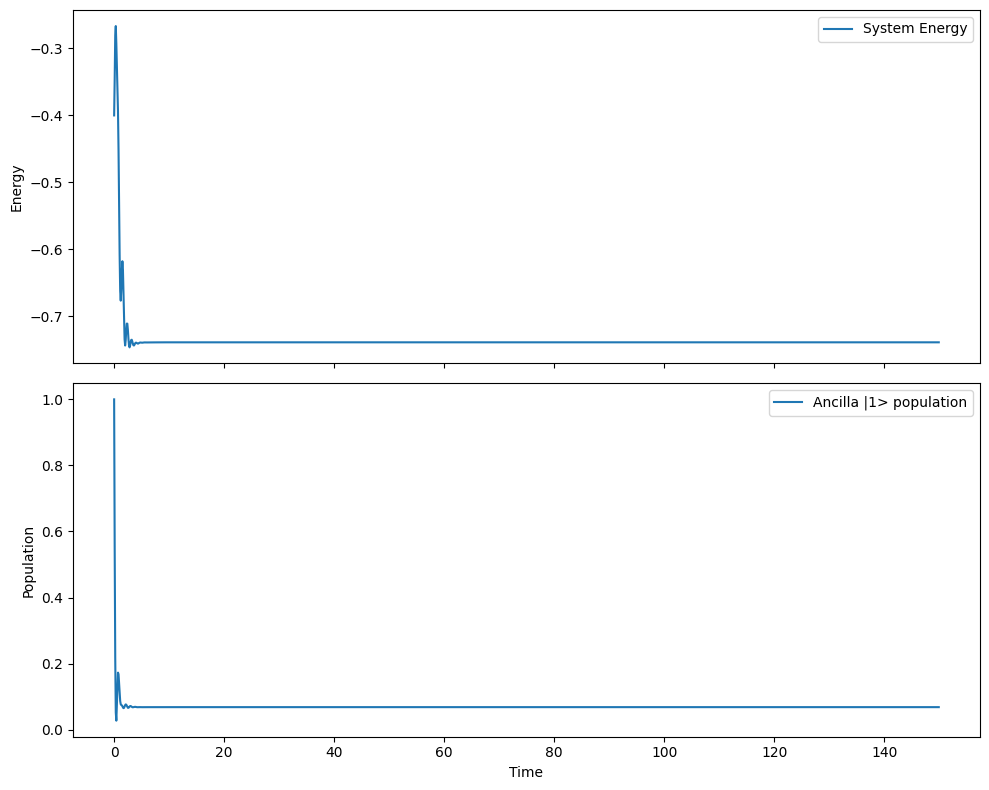


=== Running for N_sys = 4 ===
Iteration No: 1 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5529
Function value obtained: -1.2760
Current minimum: -1.2760
Iteration No: 2 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4430
Function value obtained: -0.3007
Current minimum: -1.2760
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4035
Function value obtained: -0.4958
Current minimum: -1.2760
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6395
Function value obtained: -0.2713
Current minimum: -1.2760
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4476
Function value obtained: -0.9412
Current minimum: -1.2760
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.2807
Function value obtained: -0.9714
Current minimum: -1.2760
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Ev

/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3473
Function value obtained: -0.3888
Current minimum: -1.4464
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.3517
Function value obtained: -0.4208
Current minimum: -1.4464
Iteration No: 11 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 1.4766
Function value obtained: -1.4129
Current minimum: -1.4464
Iteration No: 12 started. Searching for the next optimal point.


/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1.3046
Function value obtained: -0.1435
Current minimum: -1.4464
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.1648
Function value obtained: -1.1657
Current minimum: -1.4464
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.6889
Function value obtained: -0.9569
Current minimum: -1.4464
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.4275
Function value obtained: -1.9319
Current minimum: -1.9319
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.3333
Function value obtained: -1.9900
Current minimum: -1.9900
Iteration No: 17 st

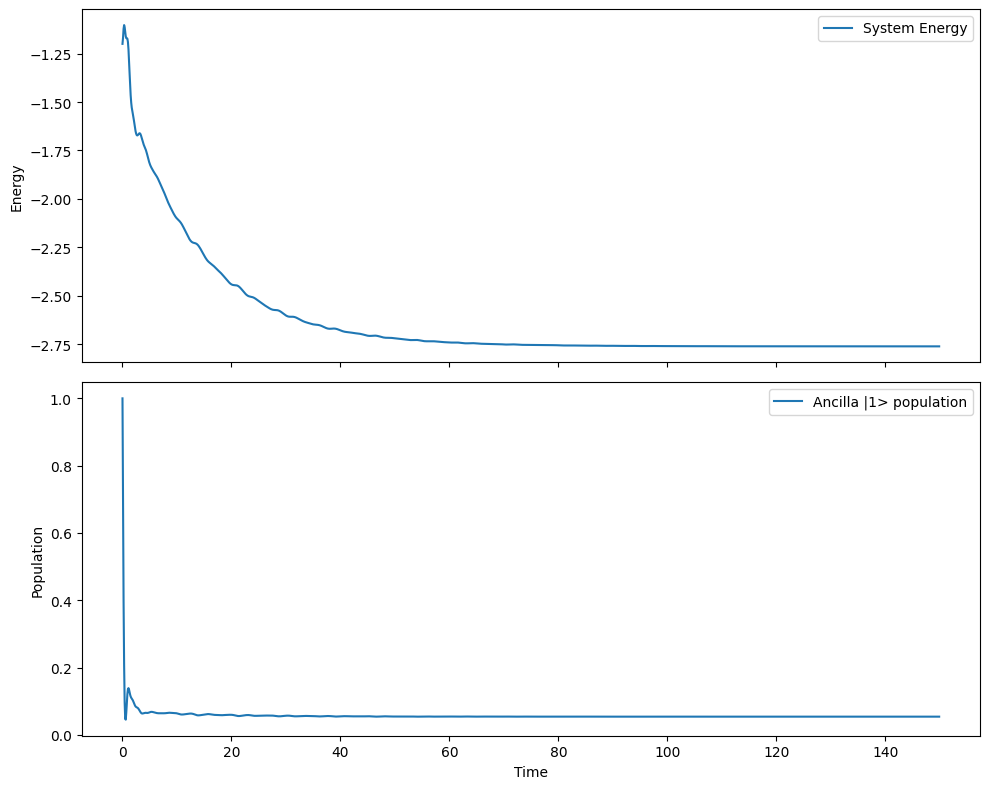


=== Running for N_sys = 6 ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.6858
Function value obtained: -2.2351
Current minimum: -2.2351
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.0588
Function value obtained: -1.0005
Current minimum: -2.2351
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 19.1654
Function value obtained: -1.3016
Current minimum: -2.2351
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.0494
Function value obtained: -1.1272
Current minimum: -2.2351
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.6793
Function value obtained: -1.8152
Current minimum:

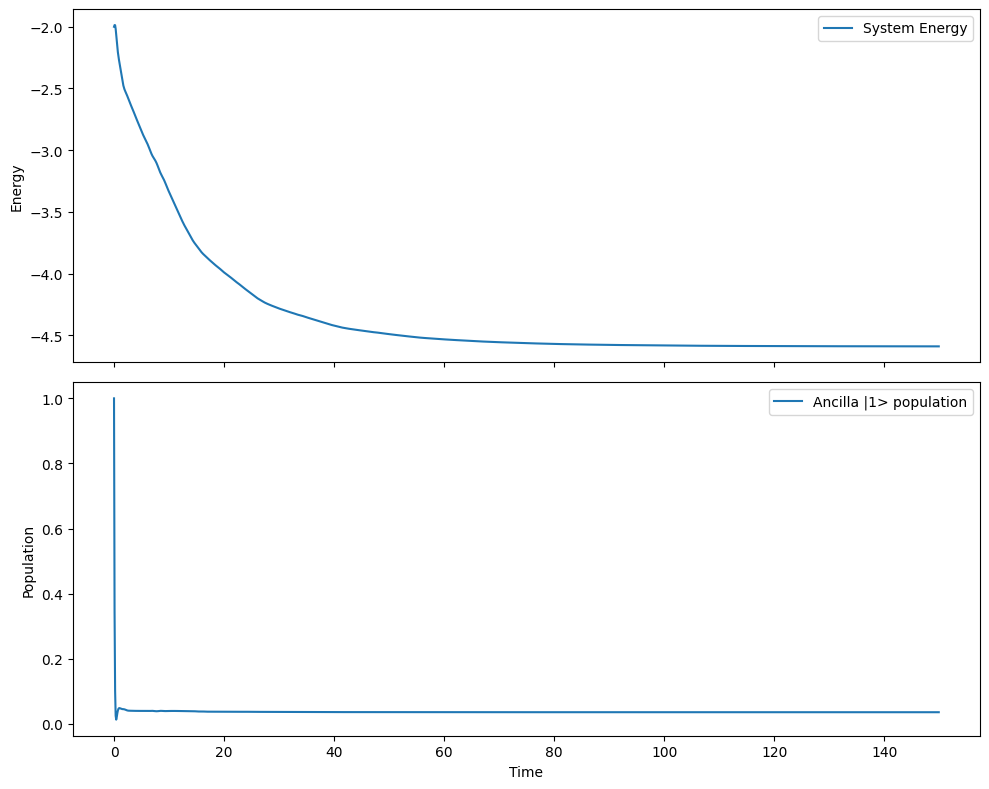


--- All simulations completed ---


In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from dataclasses import dataclass
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# Optimization Bounds
# =============================================================================
@dataclass
class OptimizationBounds:
    fx: tuple = (-2.0, 2.0)
    fy: tuple = (-2.0, 2.0)
    fz: tuple = (-2.0, 2.0)
    delta_bath: tuple = None
    gamma: tuple = (0.1, 10.0)
    gamma_local: tuple = (0.0, 0.1)
    gamma_collective: tuple = (0.0, 0.1)

# =============================================================================
# ED Class
# =============================================================================
class ED:
    def __init__(self, n_qubits: int):
        self.n = n_qubits
        id2 = qt.qeye(2)
        self.sx = [qt.tensor(*[id2]*i + [qt.sigmax()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sy = [qt.tensor(*[id2]*i + [qt.sigmay()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sz = [qt.tensor(*[id2]*i + [qt.sigmaz()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sm = [qt.tensor(*[id2]*i + [qt.sigmam()] + [id2]*(self.n-i-1)) for i in range(self.n)]

# =============================================================================
# Hamiltonian Builder
# =============================================================================
class HamiltonianBuilder:
    def __init__(self, ed: ED, J: float, hx: float, n_sys: int):
        self.ed = ed
        self.J = J
        self.hx = hx
        self.n_sys = n_sys

    def system_hamiltonian(self):
        H = 0
        for i in range(self.n_sys - 1):
            H += self.J * self.ed.sx[i] * self.ed.sx[i+1]
            H += self.hx * (self.ed.sz[i] + self.ed.sz[i+1])
        return H

    def total_hamiltonian(self, fx, fy, fz, delta):
        H_sys = self.system_hamiltonian()
        idx = self.n_sys
        H_bath = delta * self.ed.sz[idx]
        H_int = fx * self.ed.sx[idx-1] * self.ed.sx[idx]
        H_int += fy * self.ed.sy[idx-1] * self.ed.sy[idx]
        H_int += fz * self.ed.sz[idx-1] * self.ed.sz[idx]
        return H_sys + H_bath + H_int

# =============================================================================
# Collapse Operator Helper
# =============================================================================
def get_system_decoherence_ops(ed, n_sys, gamma_local, gamma_collective):
    c_ops = []
    for i in range(n_sys):
        c_ops.append(np.sqrt(gamma_local) * ed.sm[i])
    if gamma_collective > 0.0:
        L_coll = sum(ed.sm[i] for i in range(n_sys))
        c_ops.append(np.sqrt(gamma_collective) * L_coll)
    return c_ops

# =============================================================================
# Simulator
# =============================================================================
class SympatheticCoolingSimulator:
    def __init__(self, builder, bounds, n_sys, n_bath):
        self.builder = builder
        self.bounds = bounds
        self.n_sys = n_sys
        self.n_bath = n_bath
        scale = max(abs(builder.J), abs(builder.hx))
        if scale == 0: scale = 1.0
        self.bounds.delta_bath = (-1.5 * scale, 1.5 * scale)
        if 2 <= n_sys <= 6:
            try:
                ee = builder.system_hamiltonian().eigenenergies()
                ee.sort()
                gap = ee[1] - ee[0]
                lb = max(1e-4, 0.5 * gap)
                ub = max(lb + 1e-3, 1.5 * gap)
                if lb < ub:
                    self.bounds.delta_bath = (lb, ub)
                else:
                    print(f"Gap too small for N_sys={n_sys}, using fallback delta_bath.")
            except Exception as e:
                print(f"Warning: Failed gap estimate for N_sys={n_sys}: {e}")
        self.space = [
            Real(*bounds.fx, name='fx'),
            Real(*bounds.fy, name='fy'),
            Real(*bounds.fz, name='fz'),
            Real(*self.bounds.delta_bath, name='delta_bath'),
            Real(*bounds.gamma, name='gamma_ancilla_decay'),
            Real(*bounds.gamma_local, name='gamma_local'),
            Real(*bounds.gamma_collective, name='gamma_collective')
        ]
        self.objective = use_named_args(self.space)(self._objective)

    def _objective(self, fx, fy, fz, delta_bath, gamma_ancilla_decay, gamma_local, gamma_collective):
        if gamma_ancilla_decay <= 0:
            return 1e10
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys, gamma_local, gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [self.builder.system_hamiltonian()]
        try:
            res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=100000))
            return res.expect[0][-1]
        except Exception as e:
            print(f"Sim failed: {e}")
            return 1e10

    def run_optimization(self, n_calls=30, seed=42):
        return gp_minimize(self.objective, self.space, n_calls=n_calls, random_state=seed, verbose=True)

    def final_run_and_plot(self, res):
        fx, fy, fz, delta_bath, gamma_ancilla_decay, gamma_local, gamma_collective = res.x
        print(f"Optimal: fx={fx:.3f}, fy={fy:.3f}, fz={fz:.3f}, delta={delta_bath:.3f}, γ_bath={gamma_ancilla_decay:.3f}, γ_local={gamma_local:.3f}, γ_coll={gamma_collective:.3f}")
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys, gamma_local, gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        H_sys = self.builder.system_hamiltonian()
        tlist = np.arange(0, 150, 0.1)
        e_ops = [H_sys, self.builder.ed.sz[self.n_sys]]
        resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=200000))

        fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        axes[0].plot(resf.times, resf.expect[0], label="System Energy")
        axes[0].set_ylabel("Energy")
        axes[0].legend()
        pop = (resf.expect[1] + 1)/2
        axes[1].plot(resf.times, pop, label="Ancilla |1> population")
        axes[1].set_ylabel("Population")
        axes[1].set_xlabel("Time")
        axes[1].legend()
        plt.tight_layout()
        plt.show()

# =============================================================================
# Main Entry
# =============================================================================
if __name__ == '__main__':
    system_sizes = [4]
    J_val = -1.0
    hx_val = 0.2

    for n_sys in system_sizes:
        print(f"\n=== Running for N_sys = {n_sys} ===")
        n_bath = n_sys + 1
        ed = ED(n_bath)
        builder = HamiltonianBuilder(ed, J_val, hx_val, n_sys)
        bounds = OptimizationBounds()
        sim = SympatheticCoolingSimulator(builder, bounds, n_sys, n_bath)
        result = sim.run_optimization(n_calls=30)
        sim.final_run_and_plot(result)

    print("\n--- All simulations completed ---")



=== Running: LOCAL ONLY ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2476
Function value obtained: -1.1895
Current minimum: -1.1895
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3429
Function value obtained: -0.9931
Current minimum: -1.1895
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6489
Function value obtained: -1.5208
Current minimum: -1.5208
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4470
Function value obtained: -1.5861
Current minimum: -1.5861
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4619
Function value obtained: -0.7693
Current minimum: -1.5

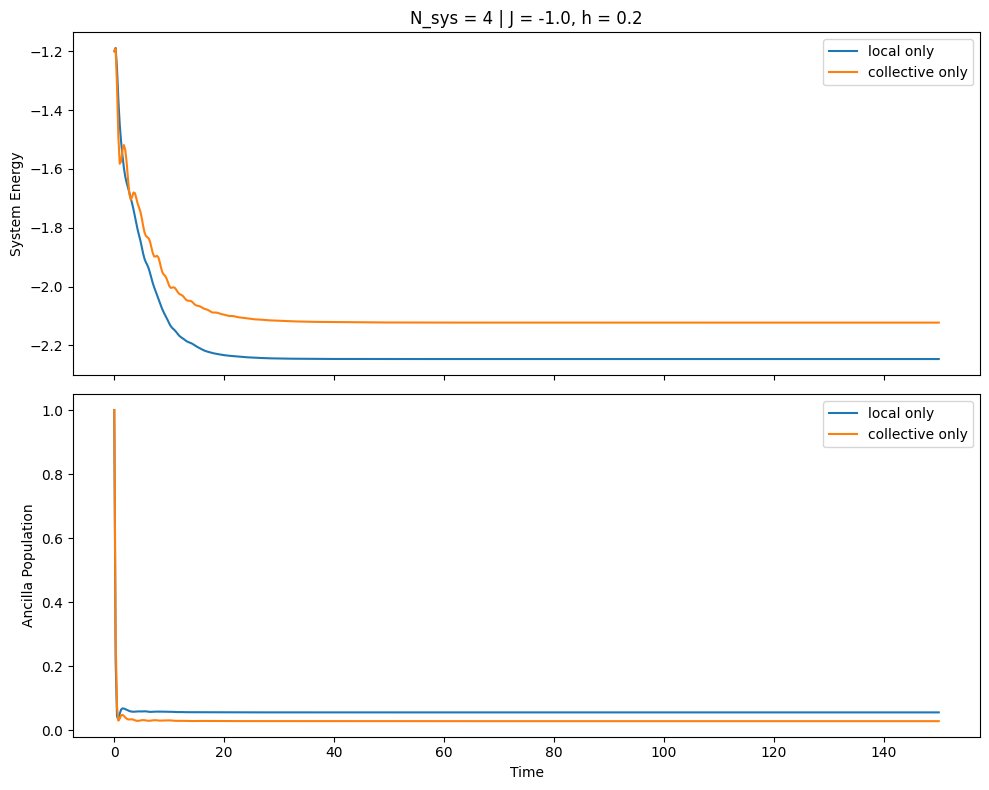


--- Comparison complete ---


In [5]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from dataclasses import dataclass
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# Optimization Bounds
# =============================================================================
@dataclass
class OptimizationBounds:
    fx: tuple = (-2.0, 2.0)
    fy: tuple = (-2.0, 2.0)
    fz: tuple = (-2.0, 2.0)
    delta_bath: tuple = None
    gamma: tuple = (0.1, 10.0)
    gamma_local: float = 0.02
    gamma_collective: float = 0.05

# =============================================================================
# ED Class
# =============================================================================
class ED:
    def __init__(self, n_qubits: int):
        self.n = n_qubits
        id2 = qt.qeye(2)
        self.sx = [qt.tensor(*[id2]*i + [qt.sigmax()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sy = [qt.tensor(*[id2]*i + [qt.sigmay()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sz = [qt.tensor(*[id2]*i + [qt.sigmaz()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sm = [qt.tensor(*[id2]*i + [qt.sigmam()] + [id2]*(self.n-i-1)) for i in range(self.n)]

# =============================================================================
# Hamiltonian Builder
# =============================================================================
class HamiltonianBuilder:
    def __init__(self, ed: ED, J: float, hx: float, n_sys: int):
        self.ed = ed
        self.J = J
        self.hx = hx
        self.n_sys = n_sys

    def system_hamiltonian(self):
        H = 0
        for i in range(self.n_sys - 1):
            H += self.J * self.ed.sx[i] * self.ed.sx[i+1]
            H += self.hx * (self.ed.sz[i] + self.ed.sz[i+1])
        return H

    def total_hamiltonian(self, fx, fy, fz, delta):
        H_sys = self.system_hamiltonian()
        idx = self.n_sys
        H_bath = delta * self.ed.sz[idx]
        H_int = fx * self.ed.sx[idx-1] * self.ed.sx[idx]
        H_int += fy * self.ed.sy[idx-1] * self.ed.sy[idx]
        H_int += fz * self.ed.sz[idx-1] * self.ed.sz[idx]
        return H_sys + H_bath + H_int

# =============================================================================
# Collapse Operator Helper
# =============================================================================
def get_system_decoherence_ops(ed, n_sys, gamma_local, gamma_collective):
    c_ops = []
    for i in range(n_sys):
        c_ops.append(np.sqrt(gamma_local) * ed.sm[i])
    if gamma_collective > 0.0:
        L_coll = sum(ed.sm[i] for i in range(n_sys))
        c_ops.append(np.sqrt(gamma_collective) * L_coll)
    return c_ops

# =============================================================================
# Simulator
# =============================================================================
class SympatheticCoolingSimulator:
    def __init__(self, builder, bounds, n_sys, n_bath):
        self.builder = builder
        self.bounds = bounds
        self.n_sys = n_sys
        self.n_bath = n_bath
        scale = max(abs(builder.J), abs(builder.hx))
        if scale == 0: scale = 1.0
        self.bounds.delta_bath = (-1.5 * scale, 1.5 * scale)
        if 2 <= n_sys <= 6:
            try:
                ee = builder.system_hamiltonian().eigenenergies()
                ee.sort()
                gap = ee[1] - ee[0]
                lb = max(1e-4, 0.5 * gap)
                ub = max(lb + 1e-3, 1.5 * gap)
                if lb < ub:
                    self.bounds.delta_bath = (lb, ub)
                else:
                    print(f"Gap too small for N_sys={n_sys}, using fallback delta_bath.")
            except Exception as e:
                print(f"Warning: Failed gap estimate for N_sys={n_sys}: {e}")
        self.space = [
            Real(*bounds.fx, name='fx'),
            Real(*bounds.fy, name='fy'),
            Real(*bounds.fz, name='fz'),
            Real(*self.bounds.delta_bath, name='delta_bath'),
            Real(*bounds.gamma, name='gamma_ancilla_decay')
        ]
        self.objective = use_named_args(self.space)(self._objective)

    def _objective(self, fx, fy, fz, delta_bath, gamma_ancilla_decay):
        gamma_local = self.bounds.gamma_local
        gamma_collective = self.bounds.gamma_collective
        if gamma_ancilla_decay <= 0:
            return 1e10
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys, gamma_local, gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [self.builder.system_hamiltonian()]
        try:
            res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=100000))
            return res.expect[0][-1]
        except Exception as e:
            print(f"Sim failed: {e}")
            return 1e10

    def run_optimization(self, n_calls=30, seed=42):
        return gp_minimize(self.objective, self.space, n_calls=n_calls, random_state=seed, verbose=True)

# =============================================================================
# Main Entry: Compare Local vs Collective Dissipation
# =============================================================================
if __name__ == '__main__':
    n_sys = 4
    n_bath = n_sys + 1
    J_val, hx_val = -1.0, 0.2

    diss_cases = {
        "local only": {"gamma_local": 0.1, "gamma_collective": 0.0},
        "collective only": {"gamma_local": 0.0, "gamma_collective": 0.1}
    }

    results = {}

    for label, gammas in diss_cases.items():
        print(f"\n=== Running: {label.upper()} ===")
        ed = ED(n_bath)
        builder = HamiltonianBuilder(ed, J_val, hx_val, n_sys)
        bounds = OptimizationBounds(
            gamma_local=gammas["gamma_local"],
            gamma_collective=gammas["gamma_collective"]
        )
        sim = SympatheticCoolingSimulator(builder, bounds, n_sys, n_bath)
        result = sim.run_optimization(n_calls=30)

        # Final simulation run
        fx, fy, fz, delta_bath, gamma_ancilla_decay = result.x
        H_tot = builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * builder.ed.sm[n_sys]]
        c_ops += get_system_decoherence_ops(builder.ed, n_sys,
                                            bounds.gamma_local,
                                            bounds.gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*n_sys + [qt.basis(2,0)]))
        tlist = np.linspace(0, 150, 600)
        e_ops = [builder.system_hamiltonian(), builder.ed.sz[n_sys]]
        resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=200000))

        results[label] = {
            "times": resf.times,
            "energy": resf.expect[0],
            "pop": (resf.expect[1] + 1) / 2
        }

    # Plot comparison
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for label in diss_cases:
        axes[0].plot(results[label]["times"], results[label]["energy"], label=label)
        axes[1].plot(results[label]["times"], results[label]["pop"], label=label)

    axes[0].set_ylabel("System Energy")
    axes[1].set_ylabel("Ancilla Population")
    axes[1].set_xlabel("Time")
    axes[0].set_title(f"N_sys = {n_sys} | J = {J_val}, h = {hx_val}")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()
    print("\n--- Comparison complete ---")



=== Running: LOCAL ONLY ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8881
Function value obtained: -1.7533
Current minimum: -1.7533
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2057
Function value obtained: -1.7993
Current minimum: -1.7993
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8814
Function value obtained: -2.3573
Current minimum: -2.3573
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.6810
Function value obtained: -3.2546
Current minimum: -3.2546
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0122
Function value obtained: -2.2394
Current minimum: -3.2

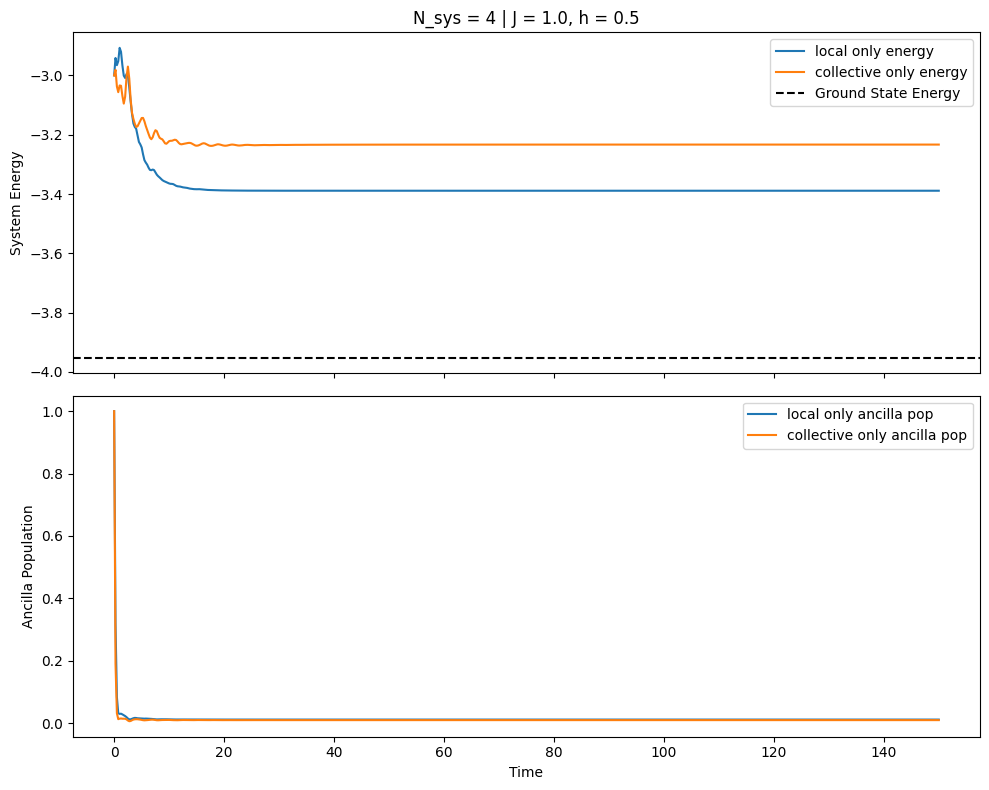


--- Comparison complete ---


In [13]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from dataclasses import dataclass
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# Optimization Bounds
# =============================================================================
@dataclass
class OptimizationBounds:
    fx: tuple = (-2.0, 2.0)
    fy: tuple = (-2.0, 2.0)
    fz: tuple = (-2.0, 2.0)
    delta_bath: tuple = None
    gamma: tuple = (0.1, 10.0)
    gamma_local: float = 0.02
    gamma_collective: float = 0.05

# =============================================================================
# ED Class
# =============================================================================
class ED:
    def __init__(self, n_qubits: int):
        self.n = n_qubits
        id2 = qt.qeye(2)
        self.sx = [qt.tensor(*[id2]*i + [qt.sigmax()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sy = [qt.tensor(*[id2]*i + [qt.sigmay()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sz = [qt.tensor(*[id2]*i + [qt.sigmaz()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sm = [qt.tensor(*[id2]*i + [qt.sigmam()] + [id2]*(self.n-i-1)) for i in range(self.n)]

# =============================================================================
# Hamiltonian Builder
# =============================================================================
class HamiltonianBuilder:
    def __init__(self, ed: ED, J: float, hx: float, n_sys: int):
        self.ed = ed
        self.J = J
        self.hx = hx
        self.n_sys = n_sys

    def system_hamiltonian(self):
        H = 0
        for i in range(self.n_sys - 1):
            H += self.J * self.ed.sx[i] * self.ed.sx[i+1]
            H += self.hx * (self.ed.sz[i] + self.ed.sz[i+1])
        return H

    def total_hamiltonian(self, fx, fy, fz, delta):
        H_sys = self.system_hamiltonian()
        idx = self.n_sys
        H_bath = delta * self.ed.sz[idx]
        H_int = fx * self.ed.sx[idx-1] * self.ed.sx[idx]
        H_int += fy * self.ed.sy[idx-1] * self.ed.sy[idx]
        H_int += fz * self.ed.sz[idx-1] * self.ed.sz[idx]
        return H_sys + H_bath + H_int

# =============================================================================
# Collapse Operator Helper
# =============================================================================
def get_system_decoherence_ops(ed, n_sys, gamma_local, gamma_collective):
    c_ops = []
    for i in range(n_sys):
        c_ops.append(np.sqrt(gamma_local) * ed.sm[i])
    if gamma_collective > 0.0:
        L_coll = sum(ed.sm[i] for i in range(n_sys))
        c_ops.append(np.sqrt(gamma_collective) * L_coll)
    return c_ops

# =============================================================================
# Simulator
# =============================================================================
class SympatheticCoolingSimulator:
    def __init__(self, builder, bounds, n_sys, n_bath):
        self.builder = builder
        self.bounds = bounds
        self.n_sys = n_sys
        self.n_bath = n_bath
        scale = max(abs(builder.J), abs(builder.hx))
        if scale == 0: scale = 1.0
        self.bounds.delta_bath = (-1.5 * scale, 1.5 * scale)
        if 2 <= n_sys <= 6:
            try:
                ee = builder.system_hamiltonian().eigenenergies()
                ee.sort()
                gap = ee[1] - ee[0]
                lb = max(1e-4, 0.5 * gap)
                ub = max(lb + 1e-3, 1.5 * gap)
                if lb < ub:
                    self.bounds.delta_bath = (lb, ub)
                else:
                    print(f"Gap too small for N_sys={n_sys}, using fallback delta_bath.")
            except Exception as e:
                print(f"Warning: Failed gap estimate for N_sys={n_sys}: {e}")
        self.space = [
            Real(*bounds.fx, name='fx'),
            Real(*bounds.fy, name='fy'),
            Real(*bounds.fz, name='fz'),
            Real(*self.bounds.delta_bath, name='delta_bath'),
            Real(*bounds.gamma, name='gamma_ancilla_decay')
        ]
        self.objective = use_named_args(self.space)(self._objective)

    def _objective(self, fx, fy, fz, delta_bath, gamma_ancilla_decay):
        gamma_local = self.bounds.gamma_local
        gamma_collective = self.bounds.gamma_collective
        if gamma_ancilla_decay <= 0:
            return 1e10
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys, gamma_local, gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [self.builder.system_hamiltonian()]
        try:
            res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=100000))
            return res.expect[0][-1]
        except Exception as e:
            print(f"Sim failed: {e}")
            return 1e10

    def run_optimization(self, n_calls=30, seed=42):
        return gp_minimize(self.objective, self.space, n_calls=n_calls, random_state=seed, verbose=True)

# =============================================================================
# Main Entry: Compare Local vs Collective Dissipation + Ground State Plot
# =============================================================================
if __name__ == '__main__':
    n_sys = 4
    n_bath = n_sys + 1
    J_val, hx_val = 1.0, 0.5

    diss_cases = {
        "local only": {"gamma_local": 0.2, "gamma_collective": 0.0},
        "collective only": {"gamma_local": 0.0, "gamma_collective": 0.2}
    }

    results = {}

    for label, gammas in diss_cases.items():
        print(f"\n=== Running: {label.upper()} ===")
        ed = ED(n_bath)
        builder = HamiltonianBuilder(ed, J_val, hx_val, n_sys)
        bounds = OptimizationBounds(
            gamma_local=gammas["gamma_local"],
            gamma_collective=gammas["gamma_collective"]
        )
        sim = SympatheticCoolingSimulator(builder, bounds, n_sys, n_bath)
        result = sim.run_optimization(n_calls=30)

        # Final simulation run
        fx, fy, fz, delta_bath, gamma_ancilla_decay = result.x
        H_tot = builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * builder.ed.sm[n_sys]]
        c_ops += get_system_decoherence_ops(builder.ed, n_sys,
                                            bounds.gamma_local,
                                            bounds.gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*n_sys + [qt.basis(2,0)]))
        tlist = np.linspace(0, 150, 600)
        e_ops = [builder.system_hamiltonian(), builder.ed.sz[n_sys]]
        resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=200000))

        results[label] = {
            "times": resf.times,
            "energy": resf.expect[0],
            "pop": (resf.expect[1] + 1) / 2
        }

    # Compute system ground state energy for reference
    H_sys = builder.system_hamiltonian()
    ground_energy = H_sys.eigenenergies()[0]
    print(f"\nGround state energy of system: {ground_energy:.6f}")

    # Plot comparison
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Energy dynamics
    for label in diss_cases:
        axes[0].plot(results[label]["times"], results[label]["energy"], label=f"{label} energy")
    axes[0].axhline(ground_energy, linestyle='--', color='black', linewidth=1.5, label='Ground State Energy')

    # Ancilla population
    for label in diss_cases:
        axes[1].plot(results[label]["times"], results[label]["pop"], label=f"{label} ancilla pop")

    axes[0].set_ylabel("System Energy")
    axes[1].set_ylabel("Ancilla Population")
    axes[1].set_xlabel("Time")
    axes[0].set_title(f"N_sys = {n_sys} | J = {J_val}, h = {hx_val}")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Comparison complete ---")



=== Running: LOCAL ONLY ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5441
Function value obtained: -1.2328
Current minimum: -1.2328
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7958
Function value obtained: 0.8176
Current minimum: -1.2328
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.5376
Function value obtained: -1.3134
Current minimum: -1.3134
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5792
Function value obtained: 2.9968
Current minimum: -1.3134
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7897
Function value obtained: 0.2783
Current minimum: -1.3134

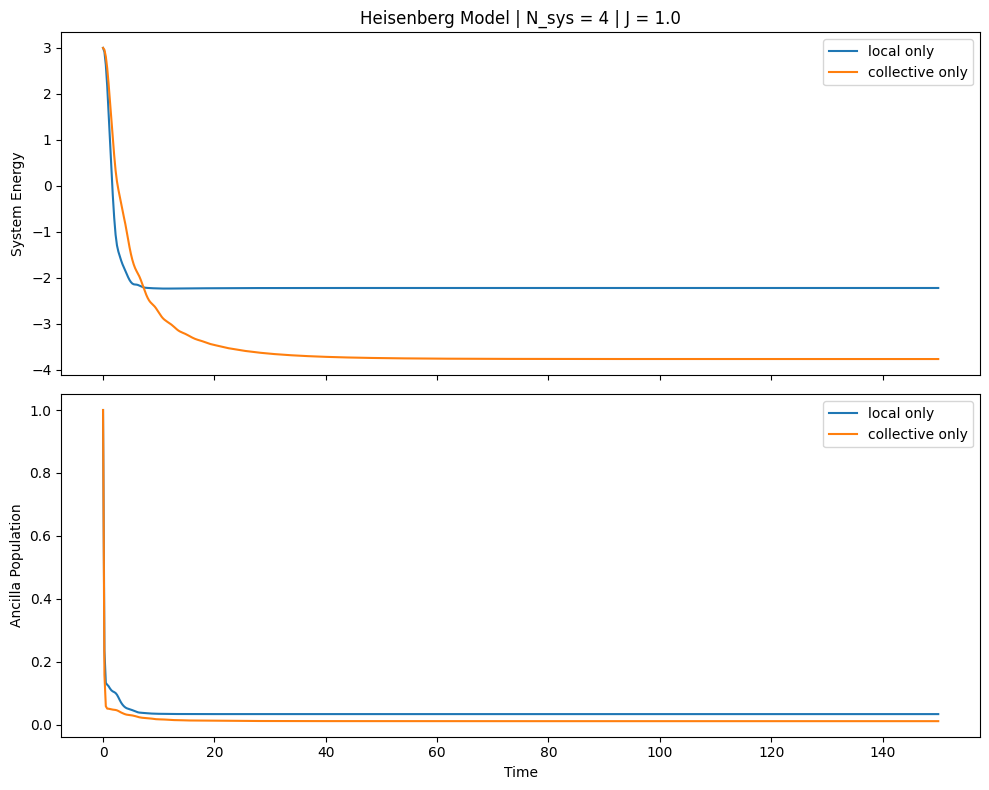


--- Comparison complete ---


In [12]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from dataclasses import dataclass
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =============================================================================
# Optimization Bounds
# =============================================================================
@dataclass
class OptimizationBounds:
    fx: tuple = (-2.0, 2.0)
    fy: tuple = (-2.0, 2.0)
    fz: tuple = (-2.0, 2.0)
    delta_bath: tuple = None
    gamma: tuple = (0.1, 10.0)
    gamma_local: float = 0.02
    gamma_collective: float = 0.05

# =============================================================================
# ED Class
# =============================================================================
class ED:
    def __init__(self, n_qubits: int):
        self.n = n_qubits
        id2 = qt.qeye(2)
        self.sx = [qt.tensor(*[id2]*i + [qt.sigmax()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sy = [qt.tensor(*[id2]*i + [qt.sigmay()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sz = [qt.tensor(*[id2]*i + [qt.sigmaz()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sm = [qt.tensor(*[id2]*i + [qt.sigmam()] + [id2]*(self.n-i-1)) for i in range(self.n)]

# =============================================================================
# Hamiltonian Builder (Heisenberg)
# =============================================================================
class HamiltonianBuilder:
    def __init__(self, ed: ED, J: float, hx: float, n_sys: int):
        self.ed = ed
        self.J = J
        self.hx = hx  # not used in Heisenberg but retained for compatibility
        self.n_sys = n_sys

    def system_hamiltonian(self):
        H = 0
        for i in range(self.n_sys - 1):
            H += self.J * (self.ed.sx[i] * self.ed.sx[i+1] +
                           self.ed.sy[i] * self.ed.sy[i+1] +
                           self.ed.sz[i] * self.ed.sz[i+1])
        return H

    def total_hamiltonian(self, fx, fy, fz, delta):
        H_sys = self.system_hamiltonian()
        idx = self.n_sys
        H_bath = delta * self.ed.sz[idx]
        H_int = fx * self.ed.sx[idx-1] * self.ed.sx[idx]
        H_int += fy * self.ed.sy[idx-1] * self.ed.sy[idx]
        H_int += fz * self.ed.sz[idx-1] * self.ed.sz[idx]
        return H_sys + H_bath + H_int

# =============================================================================
# Collapse Operator Helper
# =============================================================================
def get_system_decoherence_ops(ed, n_sys, gamma_local, gamma_collective):
    c_ops = []
    for i in range(n_sys):
        c_ops.append(np.sqrt(gamma_local) * ed.sm[i])
    if gamma_collective > 0.0:
        L_coll = sum(ed.sm[i] for i in range(n_sys))
        c_ops.append(np.sqrt(gamma_collective) * L_coll)
    return c_ops

# =============================================================================
# Simulator
# =============================================================================
class SympatheticCoolingSimulator:
    def __init__(self, builder, bounds, n_sys, n_bath):
        self.builder = builder
        self.bounds = bounds
        self.n_sys = n_sys
        self.n_bath = n_bath
        scale = max(abs(builder.J), abs(builder.hx))
        if scale == 0: scale = 1.0
        self.bounds.delta_bath = (-1.5 * scale, 1.5 * scale)
        if 2 <= n_sys <= 6:
            try:
                ee = builder.system_hamiltonian().eigenenergies()
                ee.sort()
                gap = ee[1] - ee[0]
                lb = max(1e-4, 0.5 * gap)
                ub = max(lb + 1e-3, 1.5 * gap)
                if lb < ub:
                    self.bounds.delta_bath = (lb, ub)
                else:
                    print(f"Gap too small for N_sys={n_sys}, using fallback delta_bath.")
            except Exception as e:
                print(f"Warning: Failed gap estimate for N_sys={n_sys}: {e}")
        self.space = [
            Real(*bounds.fx, name='fx'),
            Real(*bounds.fy, name='fy'),
            Real(*bounds.fz, name='fz'),
            Real(*self.bounds.delta_bath, name='delta_bath'),
            Real(*bounds.gamma, name='gamma_ancilla_decay')
        ]
        self.objective = use_named_args(self.space)(self._objective)

    def _objective(self, fx, fy, fz, delta_bath, gamma_ancilla_decay):
        gamma_local = self.bounds.gamma_local
        gamma_collective = self.bounds.gamma_collective
        if gamma_ancilla_decay <= 0:
            return 1e10
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys, gamma_local, gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [self.builder.system_hamiltonian()]
        try:
            res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=100000))
            return res.expect[0][-1]
        except Exception as e:
            print(f"Sim failed: {e}")
            return 1e10

    def run_optimization(self, n_calls=30, seed=42):
        return gp_minimize(self.objective, self.space, n_calls=n_calls, random_state=seed, verbose=True)

# =============================================================================
# Main Entry: Compare Local vs Collective Dissipation
# =============================================================================
if __name__ == '__main__':
    n_sys = 4
    n_bath = n_sys + 1
    J_val, hx_val = 1.0, 0.0  # hx not used in Heisenberg but retained

    diss_cases = {
        "local only": {"gamma_local": 0.1, "gamma_collective": 0.0},
        "collective only": {"gamma_local": 0.0, "gamma_collective": 0.1}
    }

    results = {}

    for label, gammas in diss_cases.items():
        print(f"\n=== Running: {label.upper()} ===")
        ed = ED(n_bath)
        builder = HamiltonianBuilder(ed, J_val, hx_val, n_sys)
        bounds = OptimizationBounds(
            gamma_local=gammas["gamma_local"],
            gamma_collective=gammas["gamma_collective"]
        )
        sim = SympatheticCoolingSimulator(builder, bounds, n_sys, n_bath)
        result = sim.run_optimization(n_calls=30)

        fx, fy, fz, delta_bath, gamma_ancilla_decay = result.x
        H_tot = builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * builder.ed.sm[n_sys]]
        c_ops += get_system_decoherence_ops(builder.ed, n_sys,
                                            bounds.gamma_local,
                                            bounds.gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*n_sys + [qt.basis(2,0)]))
        tlist = np.linspace(0, 150, 600)
        e_ops = [builder.system_hamiltonian(), builder.ed.sz[n_sys]]
        resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=200000))

        results[label] = {
            "times": resf.times,
            "energy": resf.expect[0],
            "pop": (resf.expect[1] + 1) / 2
        }

    # Plot comparison
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for label in diss_cases:
        axes[0].plot(results[label]["times"], results[label]["energy"], label=label)
        axes[1].plot(results[label]["times"], results[label]["pop"], label=label)

    axes[0].set_ylabel("System Energy")
    axes[1].set_ylabel("Ancilla Population")
    axes[1].set_xlabel("Time")
    axes[0].set_title(f"Heisenberg Model | N_sys = {n_sys} | J = {J_val}")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Comparison complete ---")



=== Running: LOCAL ONLY ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7049
Function value obtained: -0.1533
Current minimum: -0.1533
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0752
Function value obtained: -0.0287
Current minimum: -0.1533
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.2250
Function value obtained: -0.2362
Current minimum: -0.2362
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.4991
Function value obtained: -0.2806
Current minimum: -0.2806
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0689
Function value obtained: 0.0388
Current minimum: -0.28

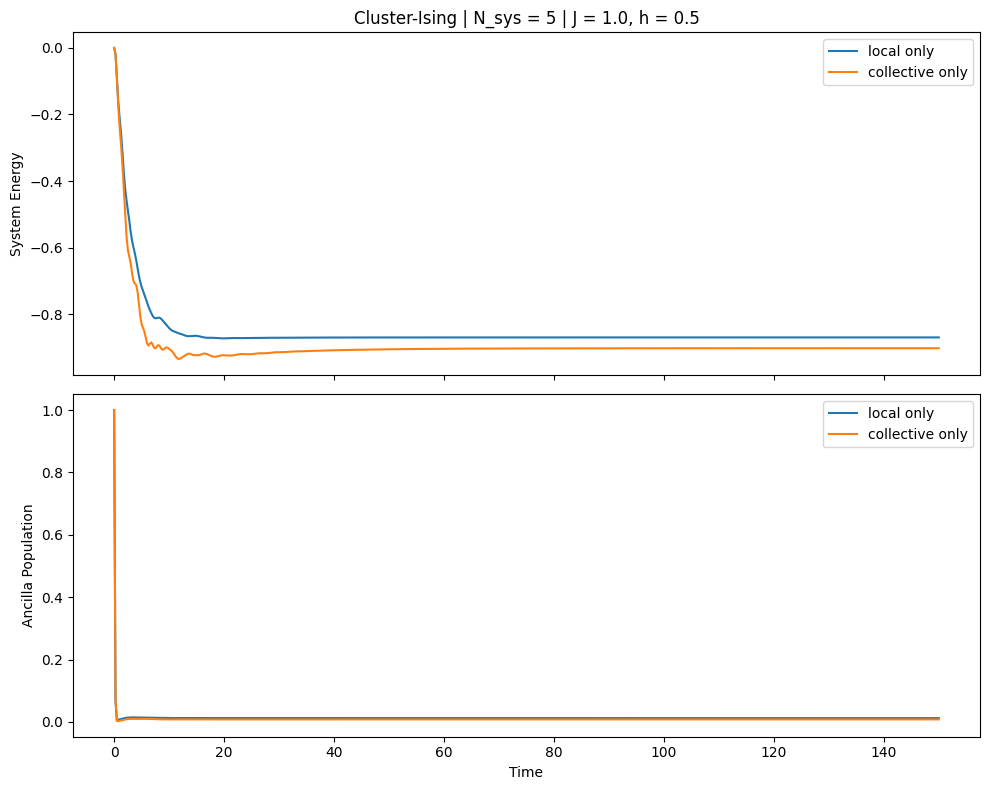


--- Cluster-Ising Cooling Comparison Complete ---


In [14]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from dataclasses import dataclass
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

@dataclass
class OptimizationBounds:
    fx: tuple = (-2.0, 2.0)
    fy: tuple = (-2.0, 2.0)
    fz: tuple = (-2.0, 2.0)
    delta_bath: tuple = None
    gamma: tuple = (0.1, 10.0)
    gamma_local: float = 0.02
    gamma_collective: float = 0.05

class ED:
    def __init__(self, n_qubits: int):
        self.n = n_qubits
        id2 = qt.qeye(2)
        self.sx = [qt.tensor(*[id2]*i + [qt.sigmax()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sy = [qt.tensor(*[id2]*i + [qt.sigmay()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sz = [qt.tensor(*[id2]*i + [qt.sigmaz()] + [id2]*(self.n-i-1)) for i in range(self.n)]
        self.sm = [qt.tensor(*[id2]*i + [qt.sigmam()] + [id2]*(self.n-i-1)) for i in range(self.n)]

class HamiltonianBuilder:
    def __init__(self, ed: ED, J: float, h: float, n_sys: int):
        self.ed = ed
        self.J = J
        self.h = h
        self.n_sys = n_sys

    def system_hamiltonian(self):
        H = 0
        # 3-body cluster interaction
        for i in range(self.n_sys - 2):
            H += -self.J * self.ed.sz[i] * self.ed.sx[i+1] * self.ed.sz[i+2]
        # transverse field term
        for i in range(self.n_sys):
            H += -self.h * self.ed.sx[i]
        return H

    def total_hamiltonian(self, fx, fy, fz, delta):
        H_sys = self.system_hamiltonian()
        idx = self.n_sys
        H_bath = delta * self.ed.sz[idx]
        H_int = fx * self.ed.sx[idx-1] * self.ed.sx[idx]
        H_int += fy * self.ed.sy[idx-1] * self.ed.sy[idx]
        H_int += fz * self.ed.sz[idx-1] * self.ed.sz[idx]
        return H_sys + H_bath + H_int

def get_system_decoherence_ops(ed, n_sys, gamma_local, gamma_collective):
    c_ops = [np.sqrt(gamma_local) * ed.sm[i] for i in range(n_sys)]
    if gamma_collective > 0.0:
        L_coll = sum(ed.sm[i] for i in range(n_sys))
        c_ops.append(np.sqrt(gamma_collective) * L_coll)
    return c_ops

class SympatheticCoolingSimulator:
    def __init__(self, builder, bounds, n_sys, n_bath):
        self.builder = builder
        self.bounds = bounds
        self.n_sys = n_sys
        self.n_bath = n_bath
        scale = max(abs(builder.J), abs(builder.h))
        self.bounds.delta_bath = (-1.5 * scale, 1.5 * scale)
        try:
            ee = builder.system_hamiltonian().eigenenergies()
            ee.sort()
            gap = ee[1] - ee[0]
            lb = max(1e-4, 0.5 * gap)
            ub = max(lb + 1e-3, 1.5 * gap)
            if lb < ub:
                self.bounds.delta_bath = (lb, ub)
        except Exception as e:
            print(f"Gap estimation failed: {e}")
        self.space = [
            Real(*bounds.fx, name='fx'),
            Real(*bounds.fy, name='fy'),
            Real(*bounds.fz, name='fz'),
            Real(*self.bounds.delta_bath, name='delta_bath'),
            Real(*bounds.gamma, name='gamma_ancilla_decay')
        ]
        self.objective = use_named_args(self.space)(self._objective)

    def _objective(self, fx, fy, fz, delta_bath, gamma_ancilla_decay):
        if gamma_ancilla_decay <= 0:
            return 1e10
        H_tot = self.builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * self.builder.ed.sm[self.n_sys]]
        c_ops += get_system_decoherence_ops(self.builder.ed, self.n_sys,
                                            self.bounds.gamma_local,
                                            self.bounds.gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*self.n_sys + [qt.basis(2,0)]))
        tlist = np.arange(0, 50, 0.5)
        e_ops = [self.builder.system_hamiltonian()]
        try:
            res = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops,
                             options=qt.Options(nsteps=100000))
            return res.expect[0][-1]
        except Exception as e:
            print(f"Simulation failed: {e}")
            return 1e10

    def run_optimization(self, n_calls=30, seed=42):
        return gp_minimize(self.objective, self.space, n_calls=n_calls, random_state=seed, verbose=True)

# =============================================================================
# Run Simulation for Cluster-Ising
# =============================================================================
if __name__ == '__main__':
    n_sys = 5  # Must be ≥ 3
    n_bath = n_sys + 1
    J_val = 1.0
    h_val = 0.5

    diss_cases = {
        "local only": {"gamma_local": 0.1, "gamma_collective": 0.0},
        "collective only": {"gamma_local": 0.0, "gamma_collective": 0.1}
    }

    results = {}

    for label, gammas in diss_cases.items():
        print(f"\n=== Running: {label.upper()} ===")
        ed = ED(n_bath)
        builder = HamiltonianBuilder(ed, J_val, h_val, n_sys)
        bounds = OptimizationBounds(
            gamma_local=gammas["gamma_local"],
            gamma_collective=gammas["gamma_collective"]
        )
        sim = SympatheticCoolingSimulator(builder, bounds, n_sys, n_bath)
        result = sim.run_optimization(n_calls=30)

        fx, fy, fz, delta_bath, gamma_ancilla_decay = result.x
        H_tot = builder.total_hamiltonian(fx, fy, fz, delta_bath)
        c_ops = [np.sqrt(gamma_ancilla_decay) * builder.ed.sm[n_sys]]
        c_ops += get_system_decoherence_ops(builder.ed, n_sys,
                                            bounds.gamma_local,
                                            bounds.gamma_collective)
        psi0 = qt.tensor(*([qt.basis(2,1)]*n_sys + [qt.basis(2,0)]))
        tlist = np.linspace(0, 150, 600)
        e_ops = [builder.system_hamiltonian(), builder.ed.sz[n_sys]]
        resf = qt.mesolve(H_tot, psi0, tlist, c_ops, e_ops, options=qt.Options(nsteps=200000))

        results[label] = {
            "times": resf.times,
            "energy": resf.expect[0],
            "pop": (resf.expect[1] + 1) / 2
        }

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for label in diss_cases:
        axes[0].plot(results[label]["times"], results[label]["energy"], label=label)
        axes[1].plot(results[label]["times"], results[label]["pop"], label=label)

    axes[0].set_ylabel("System Energy")
    axes[1].set_ylabel("Ancilla Population")
    axes[1].set_xlabel("Time")
    axes[0].set_title(f"Cluster-Ising | N_sys = {n_sys} | J = {J_val}, h = {h_val}")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Cluster-Ising Cooling Comparison Complete ---")
